# Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.api import tsa
from sklearn.preprocessing import MinMaxScaler

# Load data

### Load the hourly NO$_2$ data

In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

### Load the hourly meteorology data

In [3]:
heathrow = MetData("Heathrow")

### Load the daily disposable income data

In [4]:
income = IncomeData()

### Load the daily mortality per capita data

In [5]:
mortality = HealthData()

In [6]:
mortality_df = mortality.read("mortality-scaled")
mortality_df["deaths_per_100k"] = mortality_df["deaths"]*100000

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
mortality_df.shape

(13698, 2)

# Process data + plots

## Daily data

In [8]:
daily_dates = mortality_df.index

### Resample the hourly NO$_2$ data using a custom date list

Only retain the NO$_2$ data up to the final mortality datapoint:

In [9]:
#daily_NO2_df = NO2.resample_time_and_log(daily_dates)

In [16]:
#daily_NO2_df = NO2.read("laqn-resample")

In [17]:
#daily_NO2_df.shape

### Spatially average the NO$_2$ data for all of London

In [13]:
#NO2_df = NO2.regional_average_and_log()

In [9]:
NO2_df = NO2.read("laqn-regional")

wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [10]:
NO2_df.shape

(8401, 1)

In [11]:
NO2_df.index.min()

Timestamp('1996-01-01 00:00:00')

#### Scatter plot mortality vs NO$_2$

In [12]:
NO2_df = NO2_df.join(mortality_df)

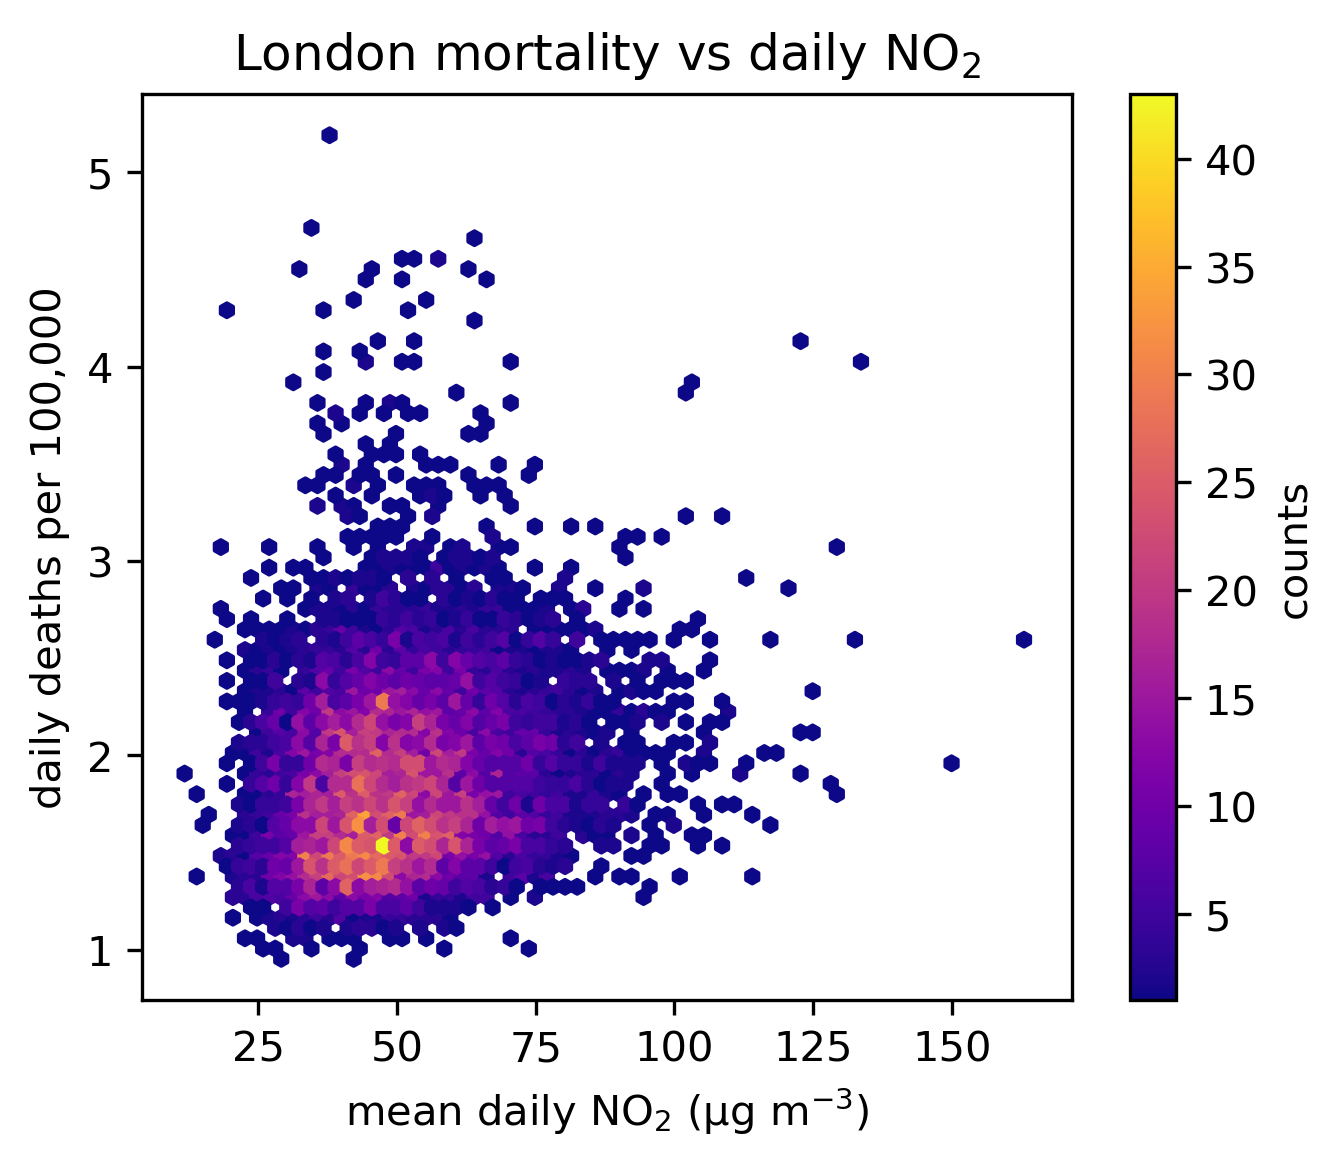

In [31]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(NO2_df.mean_NO2, NO2_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.title("London mortality vs daily NO$_2$")
plt.colorbar().set_label("counts")
plt.show()

### Resample the hourly meteorology data using a custom date list

Only retain the met data up to the final mortality datapoint:

In [10]:
#daily_met_df = heathrow.resample_time_and_log(daily_dates)

In [13]:
daily_met_df = heathrow.read(["temperature"], "met-resample")

wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [14]:
daily_met_df.shape

(13694, 1)

In [15]:
temperature_df = pd.DataFrame(daily_met_df["temperature"]).join(mortality_df)

#### Scatter plot of mortality vs temperature

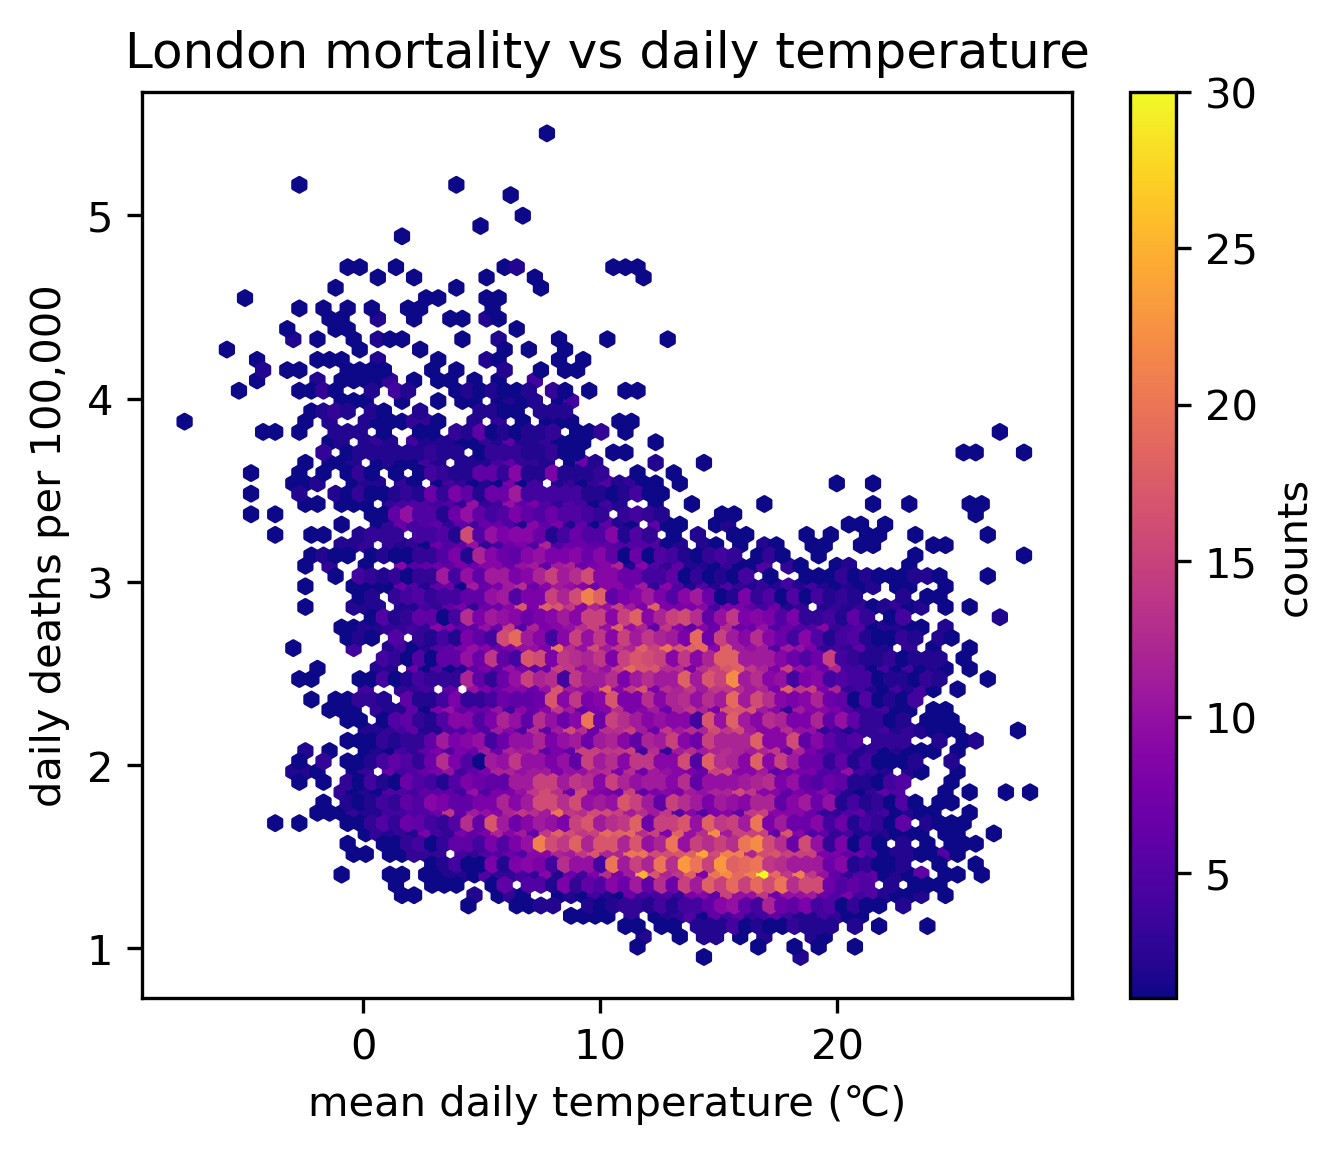

In [16]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(temperature_df.temperature, temperature_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily temperature (℃)")
plt.title("London mortality vs daily temperature")
plt.colorbar().set_label("counts")
plt.show()

### Scatter plot of NO$_2$ vs temperature

#### Daily averages

In [17]:
daily_df = pd.DataFrame(NO2_df["mean_NO2"]).join(temperature_df)

In [18]:
daily_df.columns

Index(['mean_NO2', 'temperature', 'deaths', 'deaths_per_100k'], dtype='object')

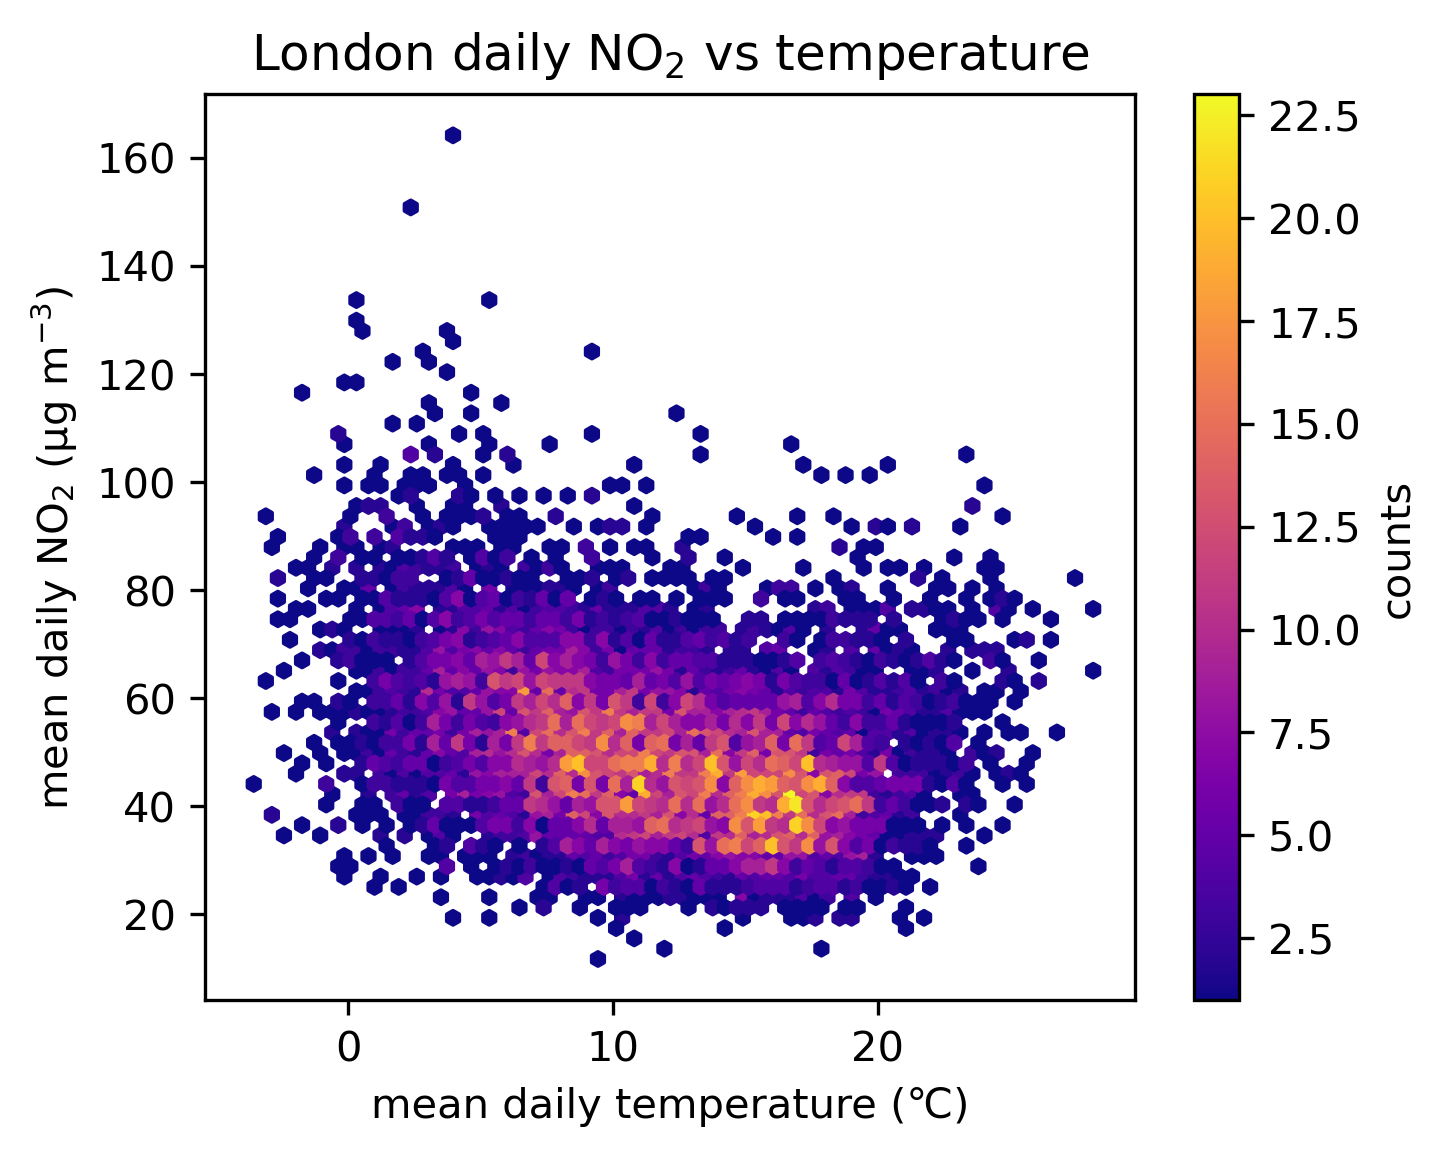

In [39]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(daily_df.temperature, daily_df.mean_NO2, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.xlabel("mean daily temperature (℃)")
plt.title("London daily NO$_2$ vs temperature")
plt.colorbar().set_label("counts")
plt.show()

### Spatially average the disposable income data for all of London

In [23]:
#income_df = income.regional_average_and_log()

In [19]:
income_df = income.read("income-regional")

wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
income_df.shape

(7671, 1)

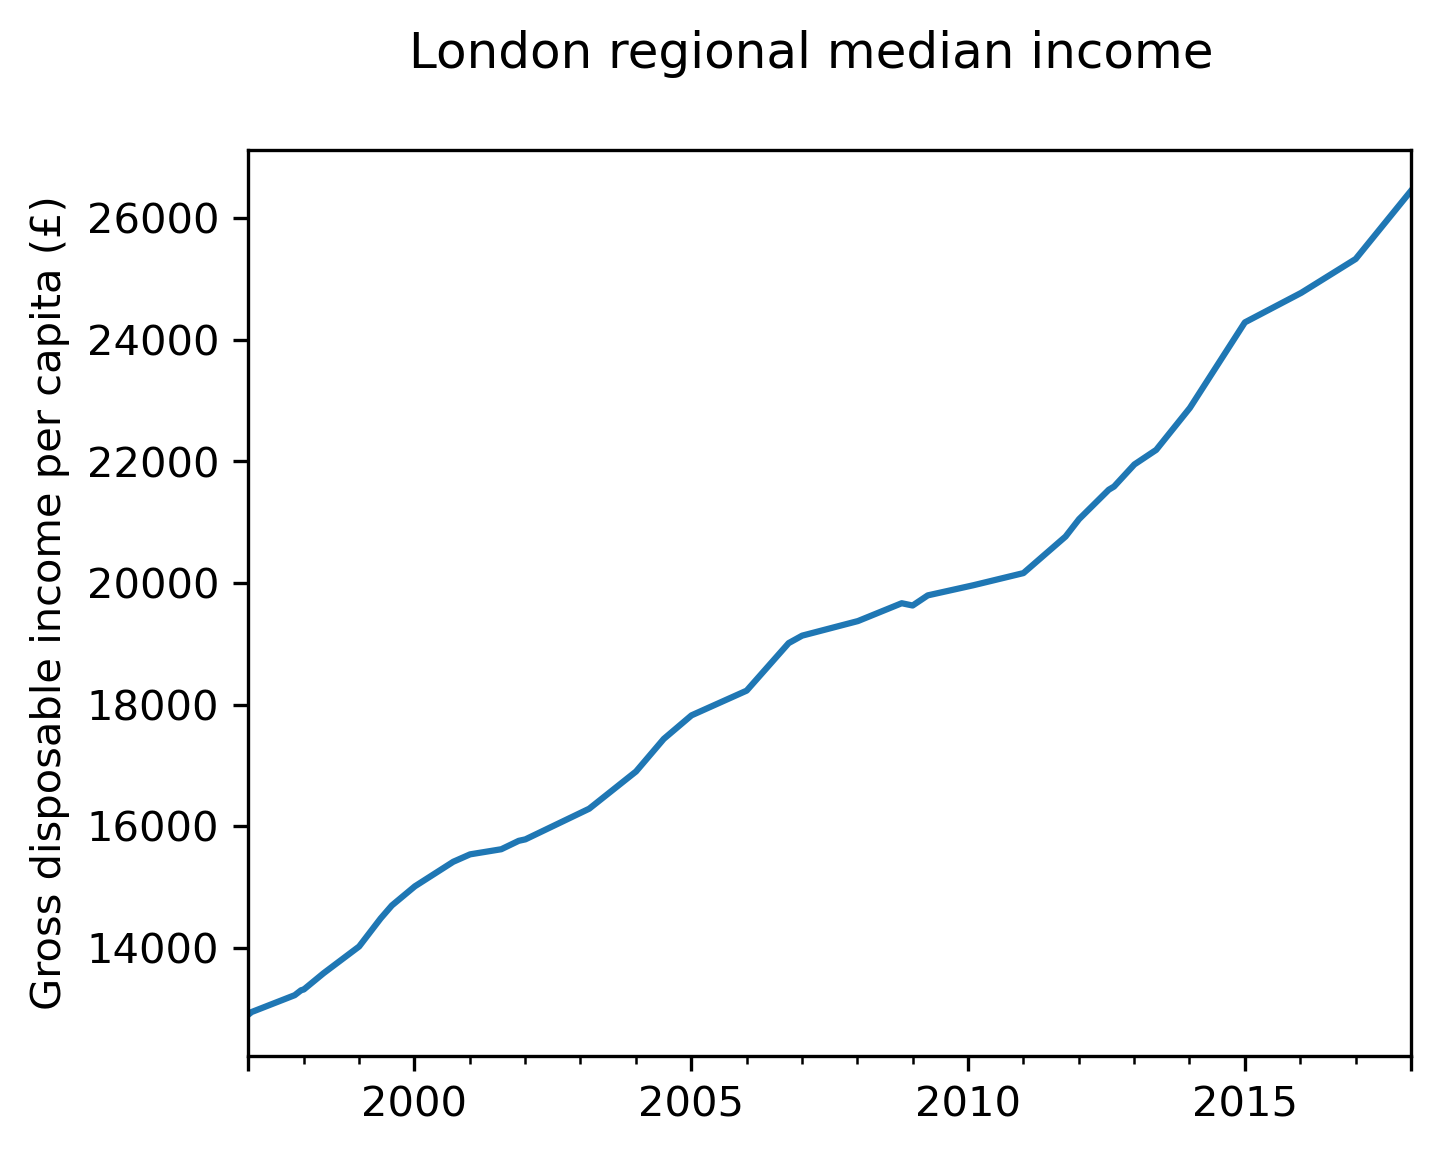

In [42]:
plt.figure(figsize=(5,4), dpi=300)
income_df["income"].plot()
plt.ylabel("Gross disposable income per capita (£)")
plt.suptitle("London regional median income")
plt.show()

#### Scatter plot mortality vs disposable income

In [21]:
income_df = income_df.join(mortality_df)

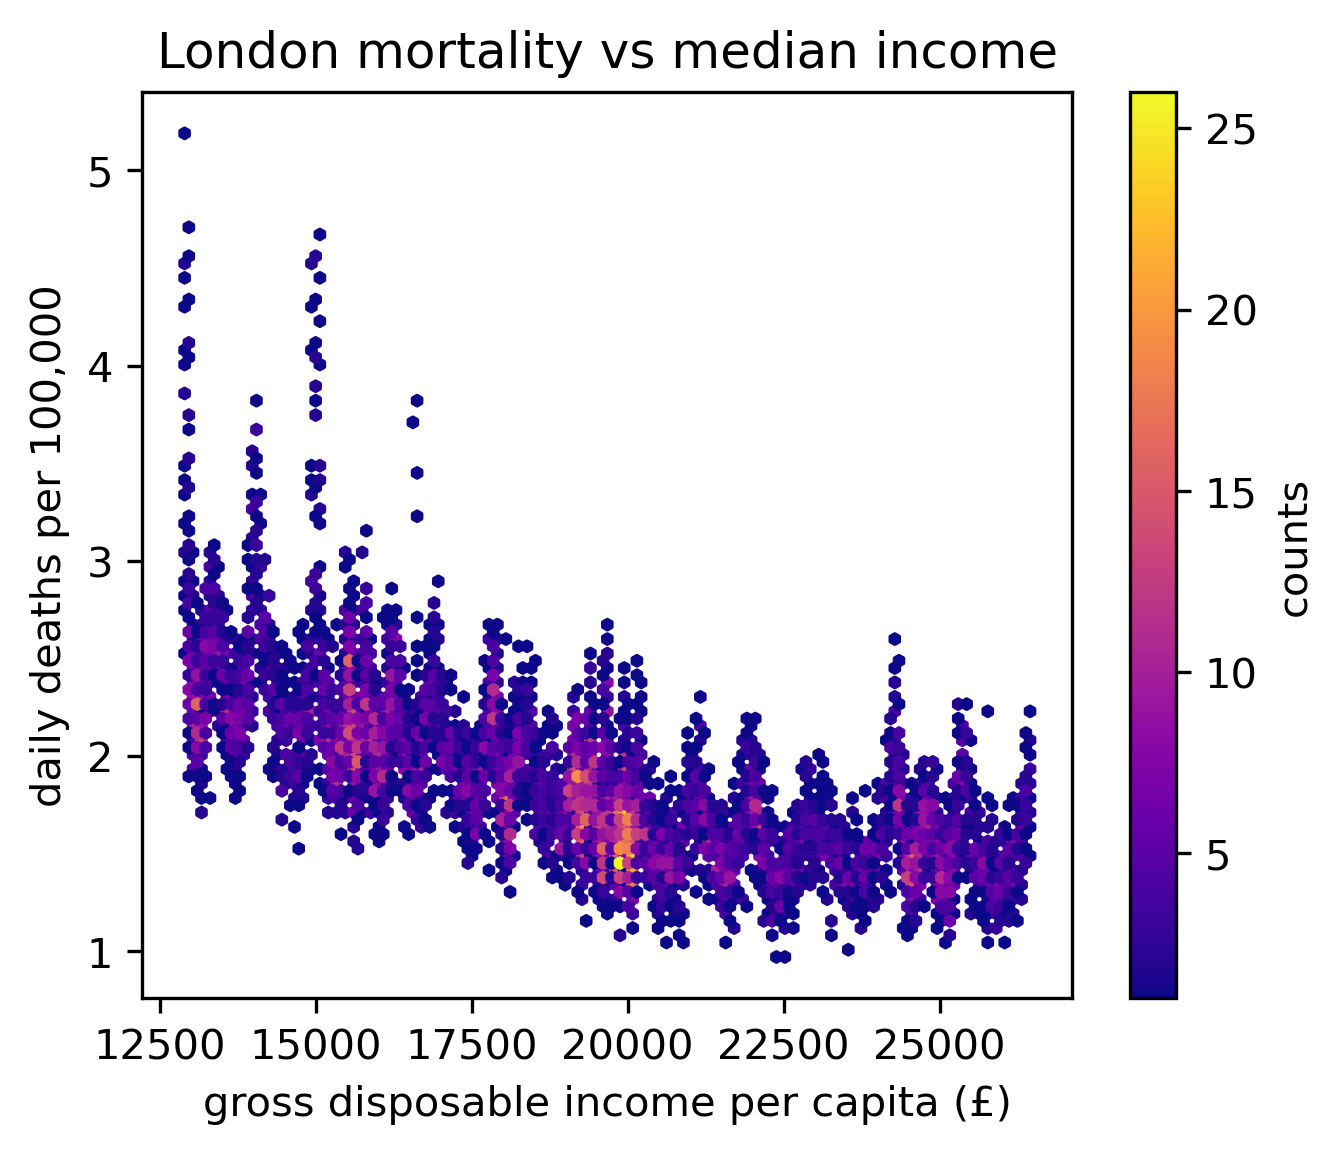

In [45]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(income_df.income, income_df.deaths_per_100k, cmap=cm.plasma, gridsize=100, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("gross disposable income per capita (£)")
plt.title("London mortality vs median income")
plt.colorbar().set_label("counts")
plt.show()

## Time series decomposition: trends

**Trends** represent how the variable is changing overall through time.
**Seasonality** shows how the variable changes within a given period e.g. year, month.
**Residual** activity is not explained by the trend or seasonality.

Additive model: 
`y(t) = Trend(t) + Seasonality(t) + Residual(t)`

Multiplicative model:
`y(t) = Trend(t) * Seasonality(t) * Residual(t)`

In [22]:
decomp_dict = {}

In [28]:
def plot_seasonal_decomposition(title, units, decomp_df, seasonal_year_plot=2010):
    
    plt.figure(figsize=(5,4), dpi=300)
    decomp_df["observed"].plot()
    decomp_df["trend"].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

    plt.figure(figsize=(5,4), dpi=300)
    decomp_df["trend"].plot(color="tab:orange")
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(f"{title}: trend")
    plt.show()

    plt.figure(figsize=(5,4), dpi=300)
    decomp_df.loc[decomp_df.index.year==seasonal_year_plot]["seasonal"].plot(color="tab:green")
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(f"{title}: seasonal variation")
    plt.show()

    plt.figure(figsize=(5,4), dpi=300)
    decomp_df["residual"].plot(color="tab:red")
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(f"{title}: residuals")
    plt.show()

#### Mortality data

Here we use the `seasonal_decompose()` function with an additive model. Note that we have to manually set `period` (for filtering) to `365`, because otherwise the function by default looks for weekly (`period=7`) trends when given daily data (inferred from the `DatetimeIndex`).

In [25]:
decomp = tsa.seasonal_decompose(mortality_df["deaths_per_100k"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_dict["mortality"] = decomp_df

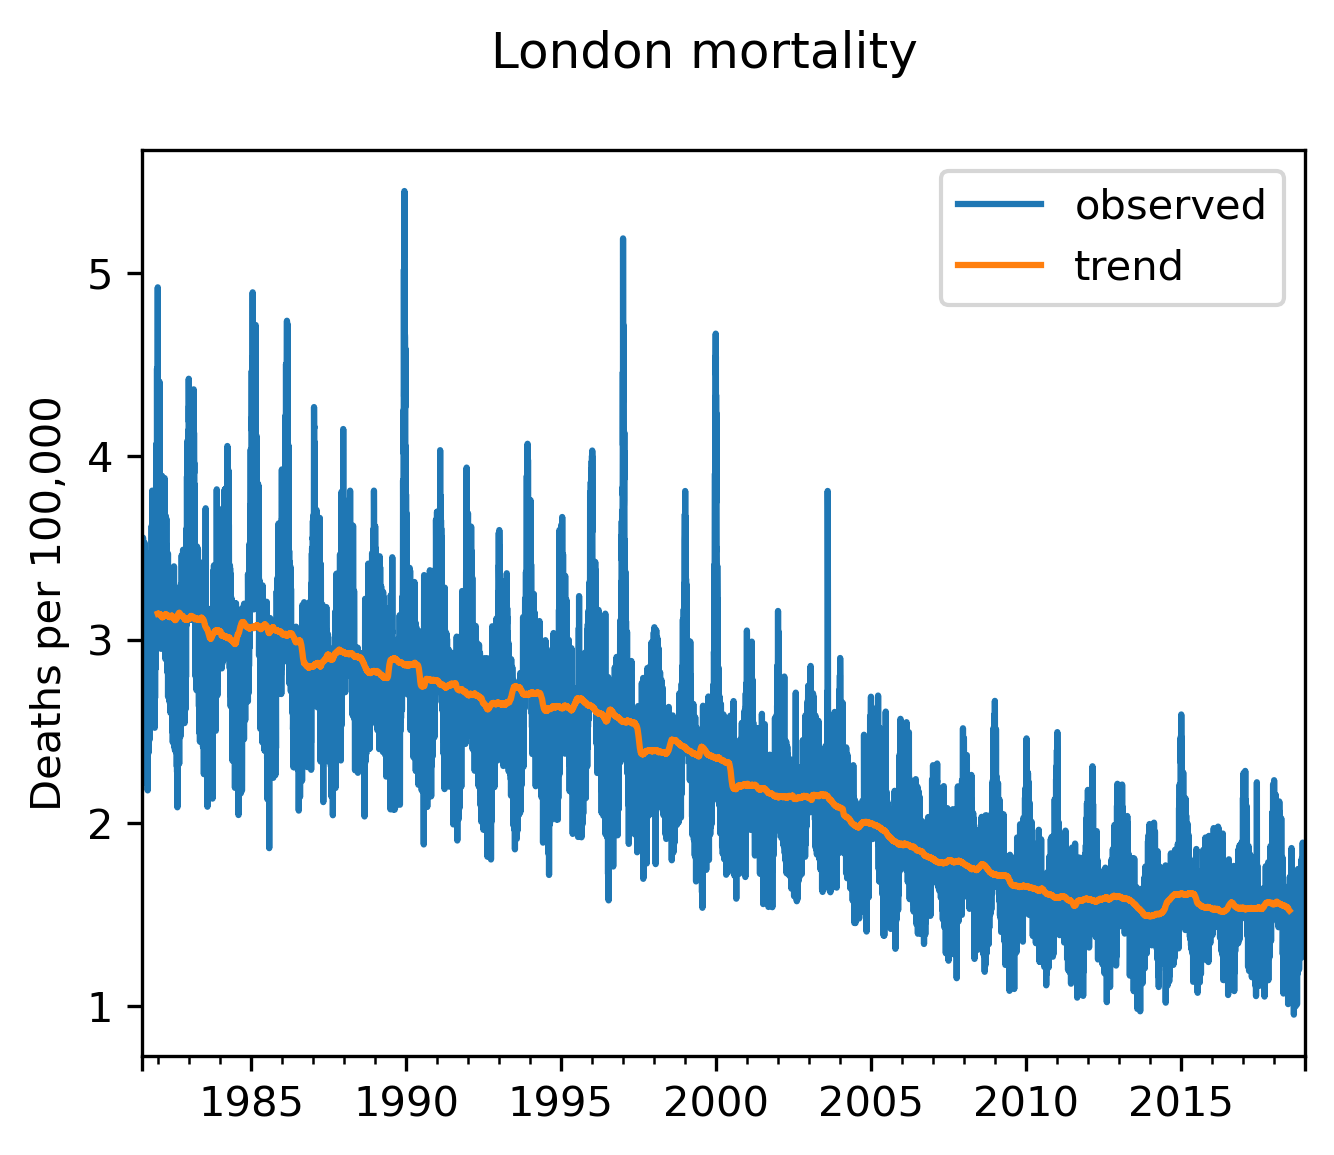

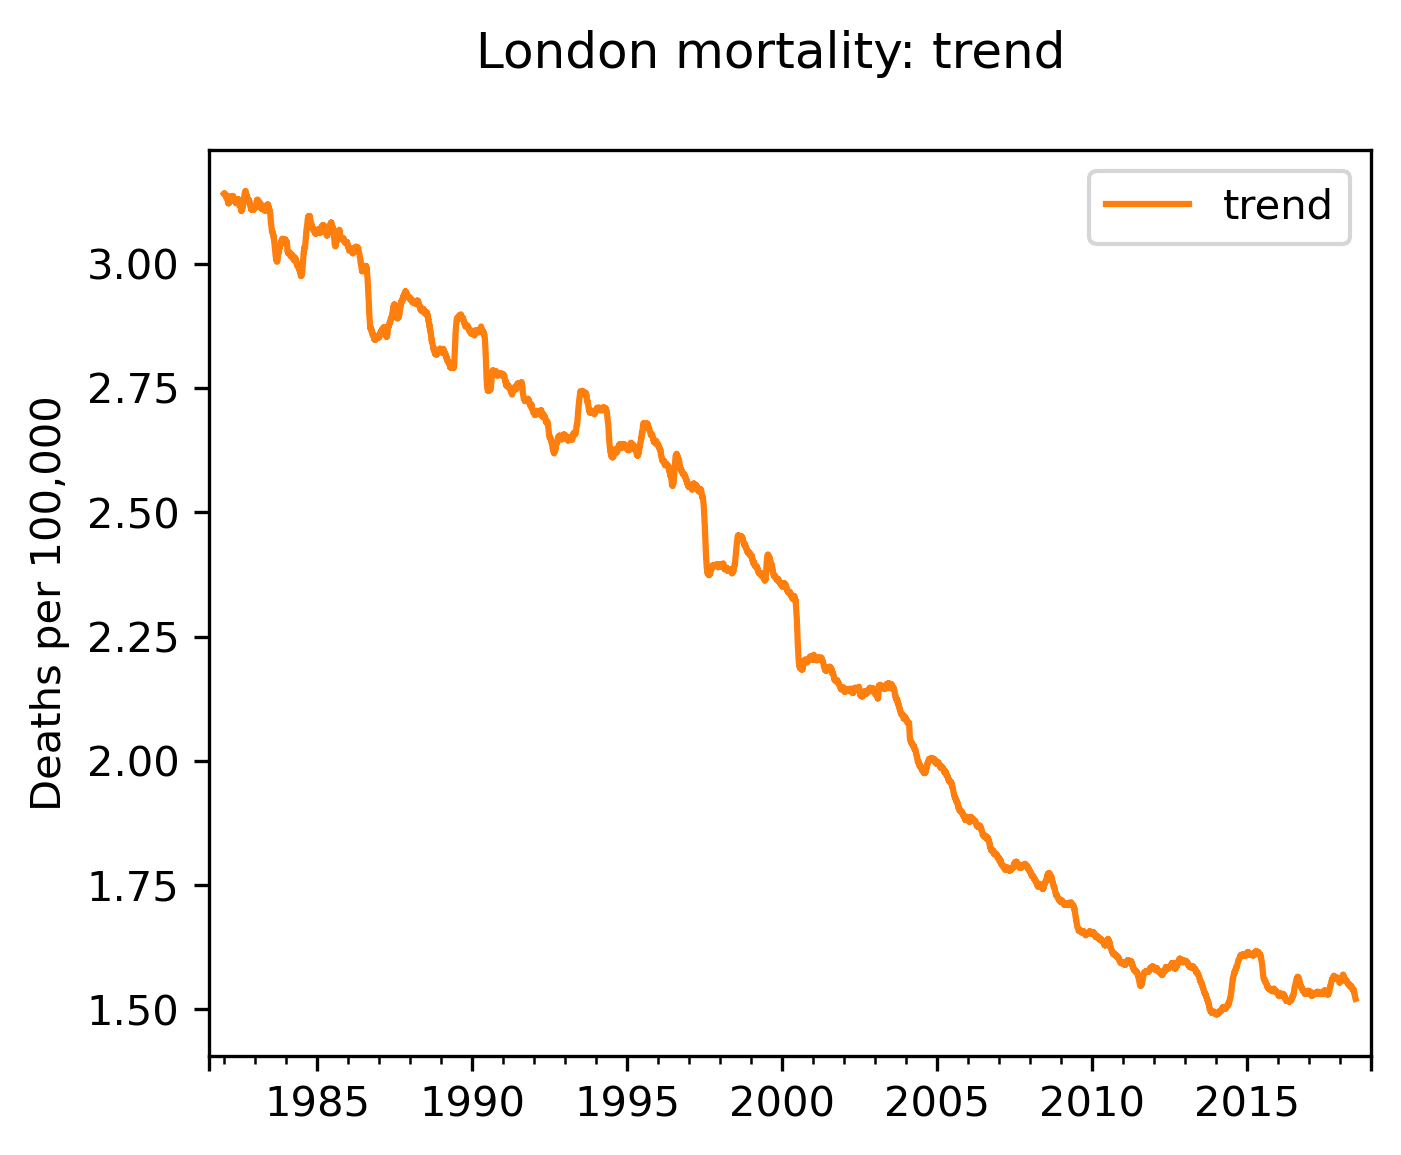

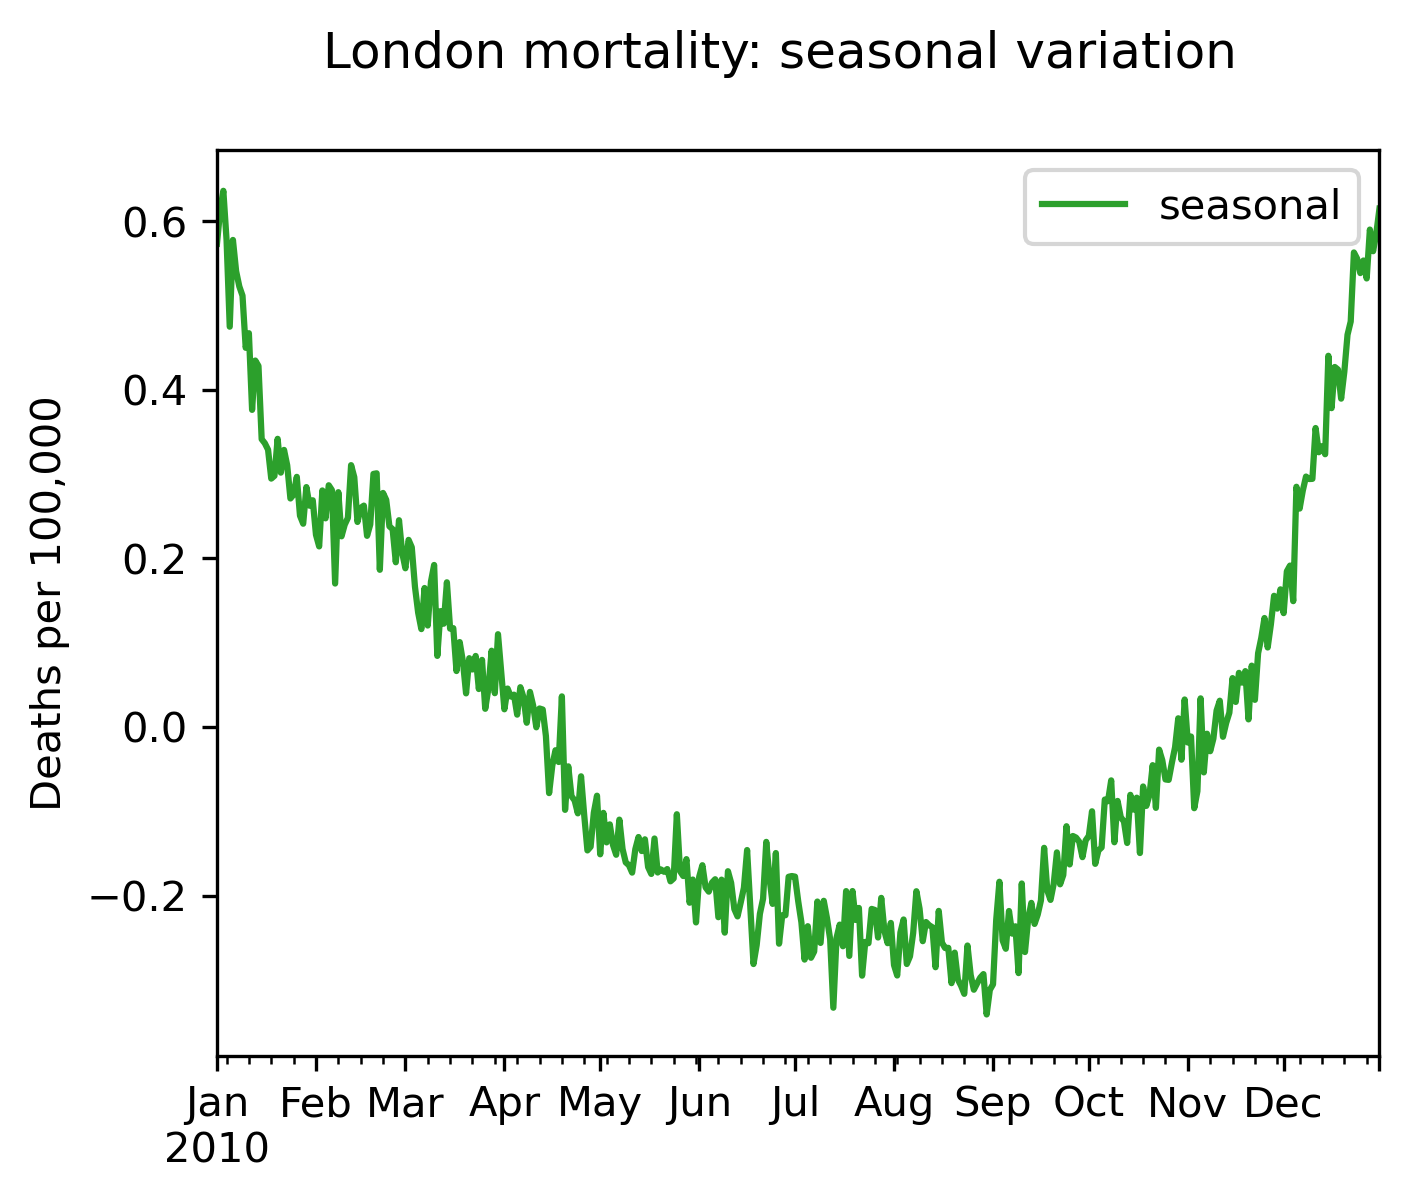

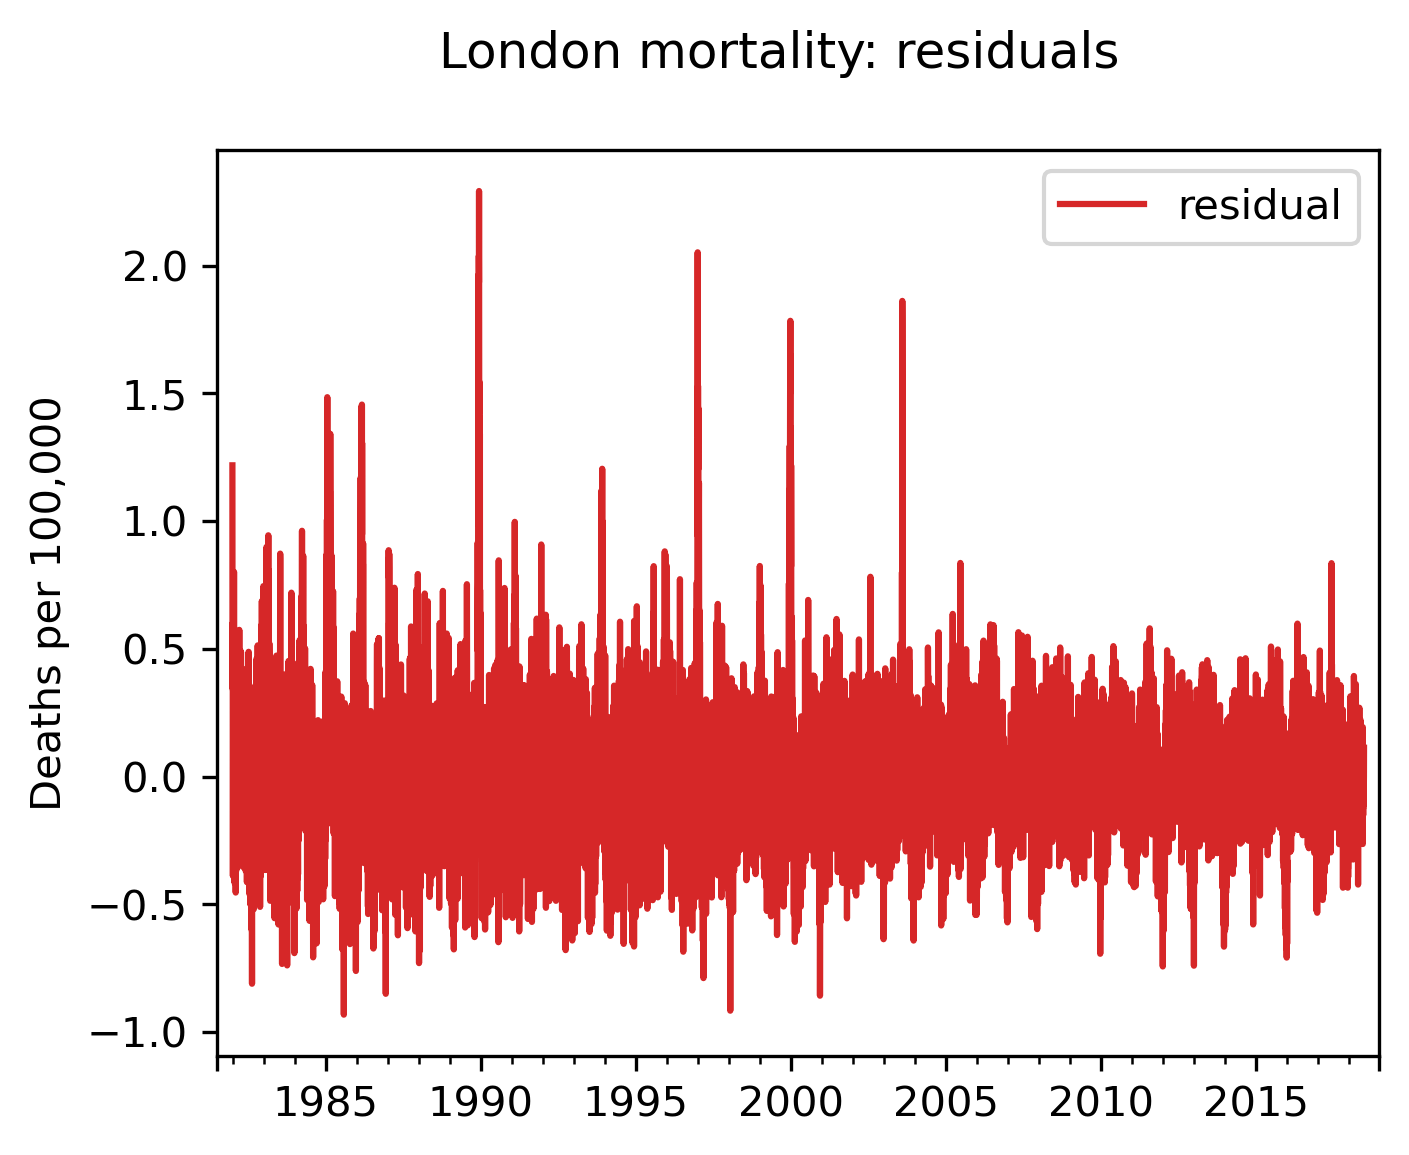

In [29]:
title = "London mortality"
units = "Deaths per 100,000"

plot_seasonal_decomposition(title, units, decomp_df, 2010)

#### NO$_2$ data

In [30]:
decomp = tsa.seasonal_decompose(daily_df["mean_NO2"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_dict["NO2"] = decomp_df

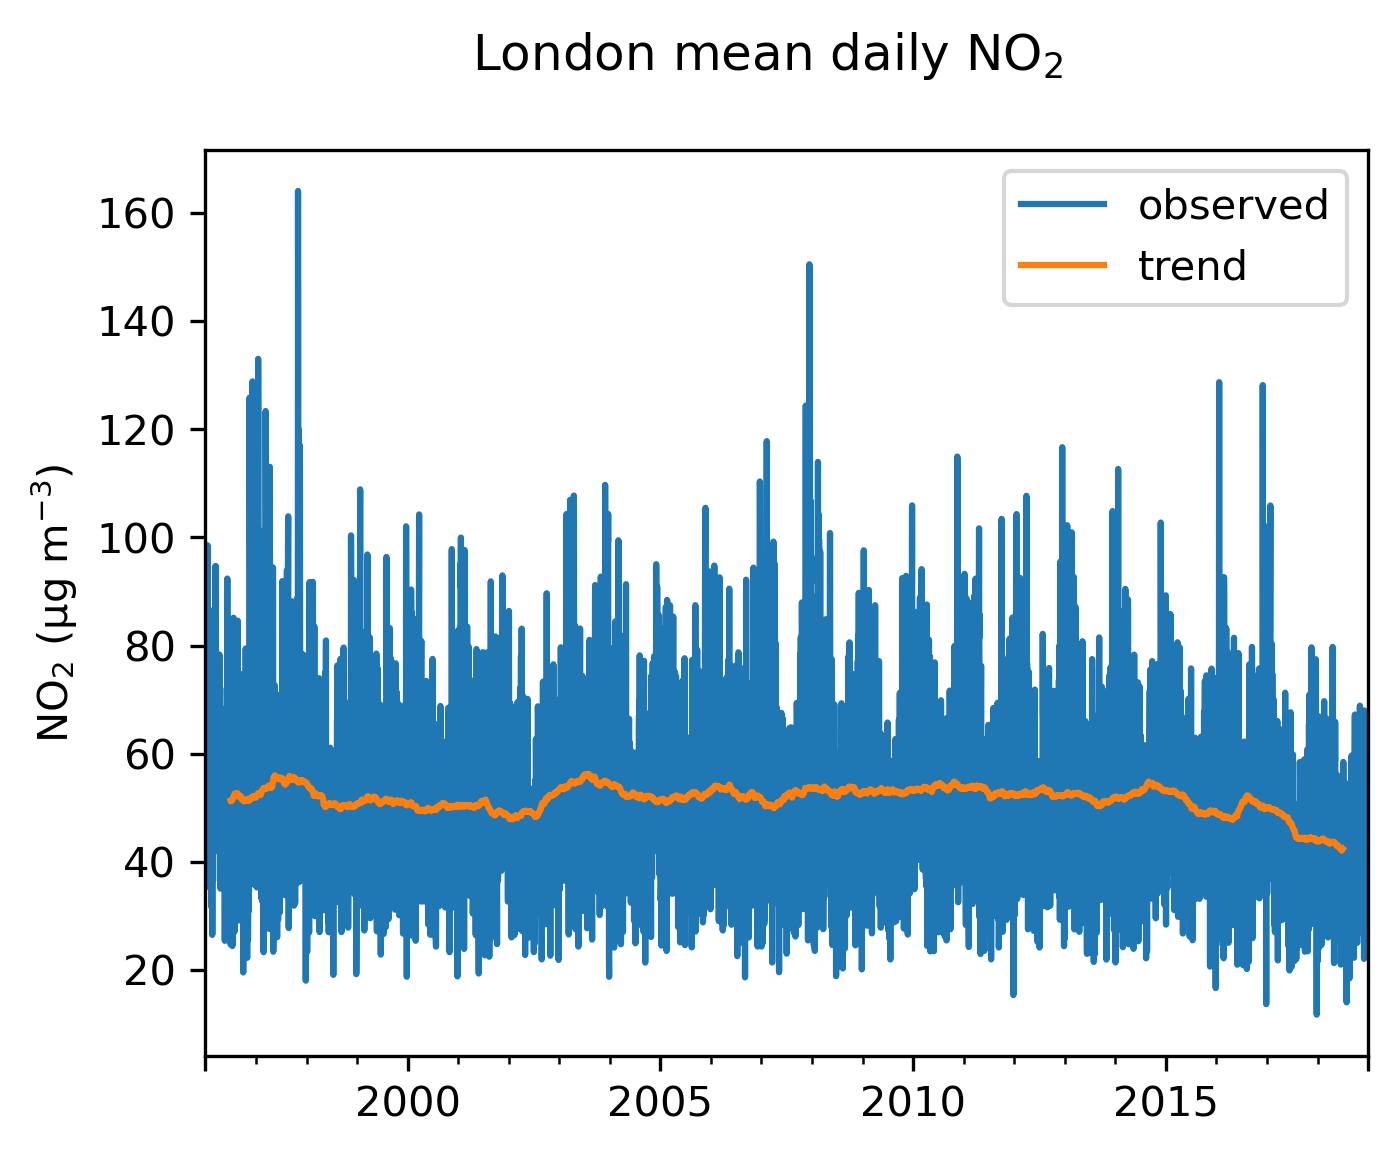

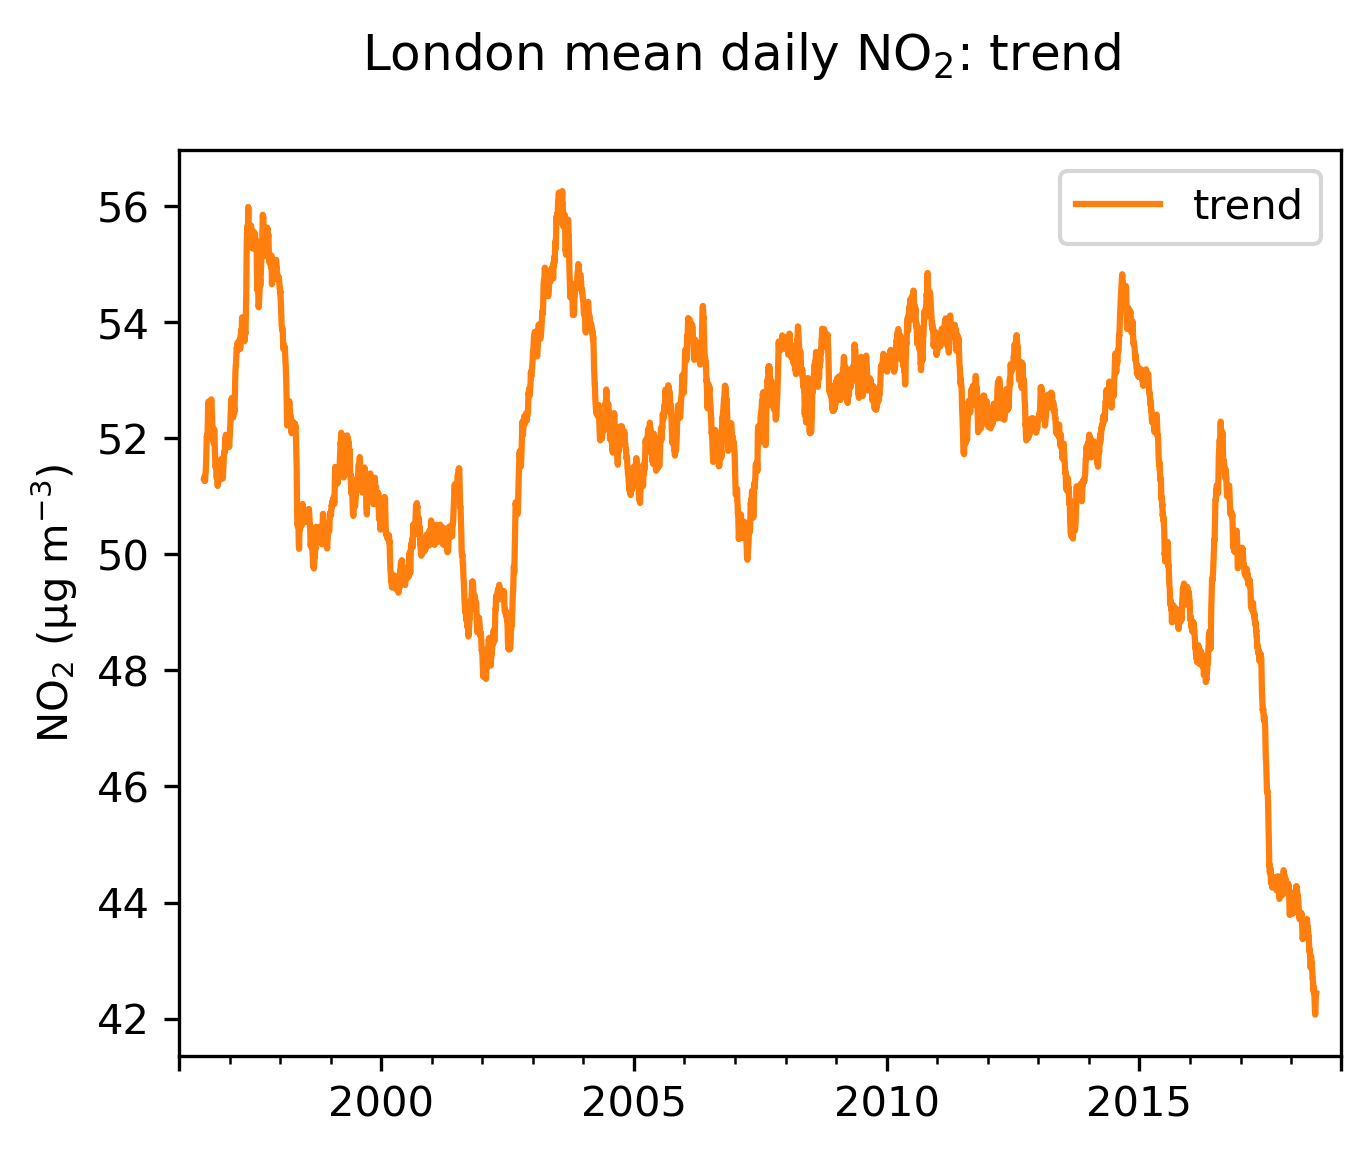

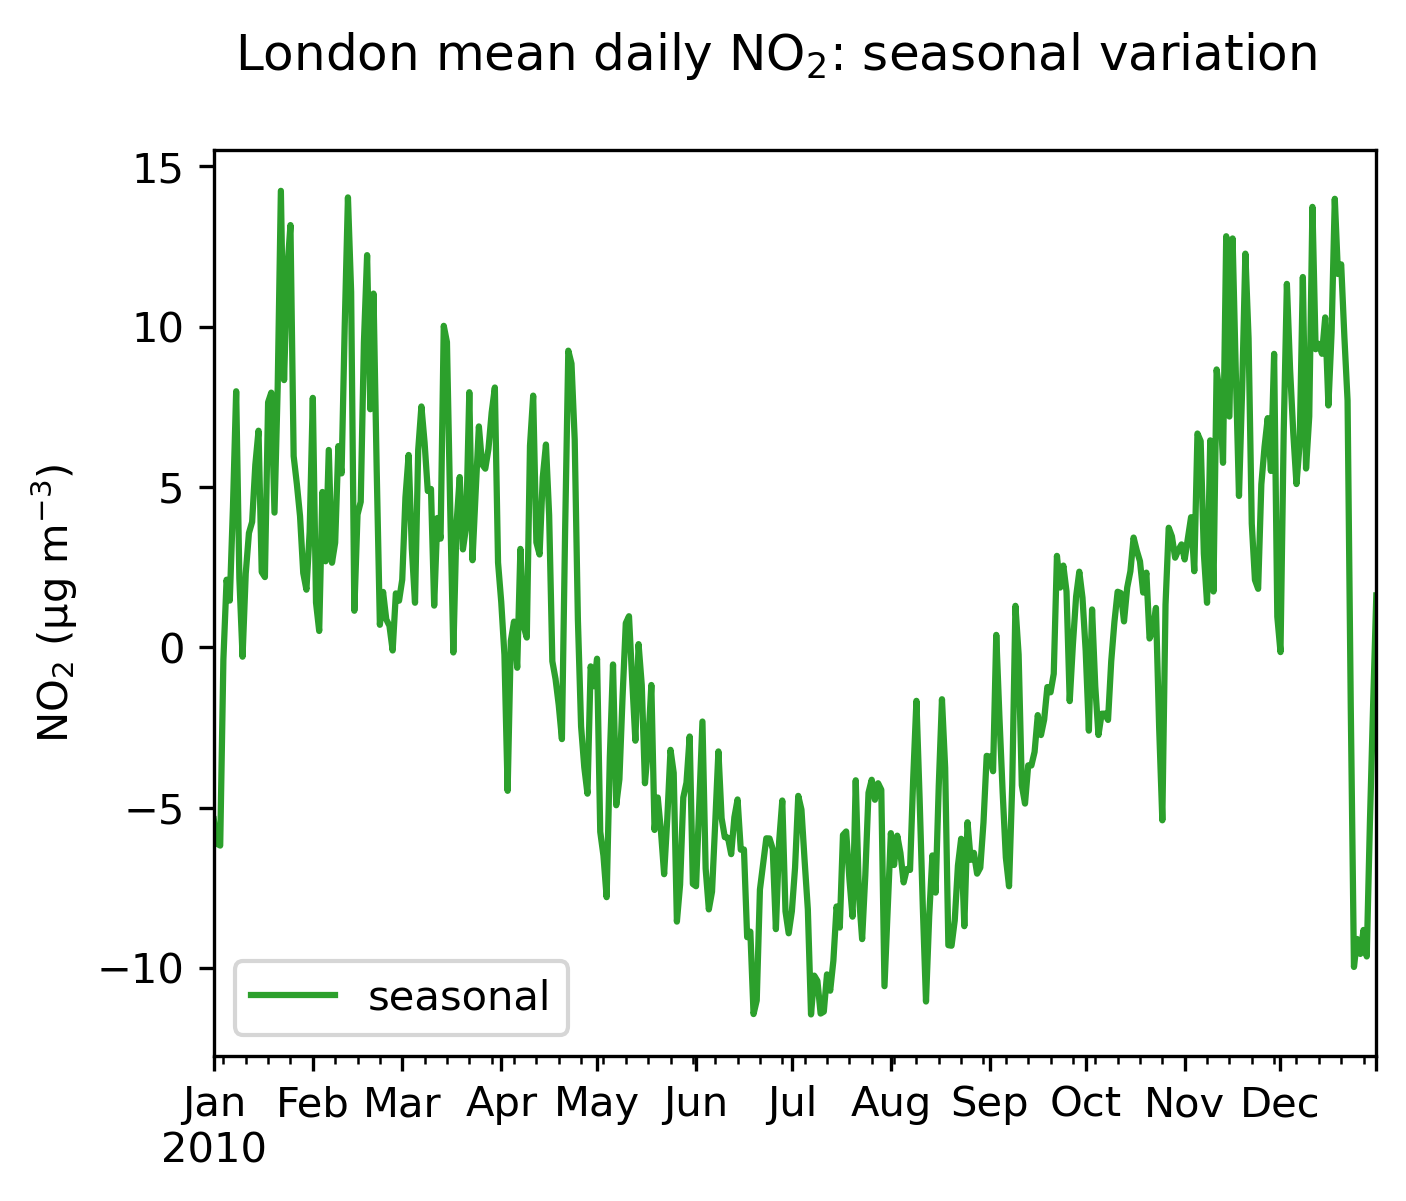

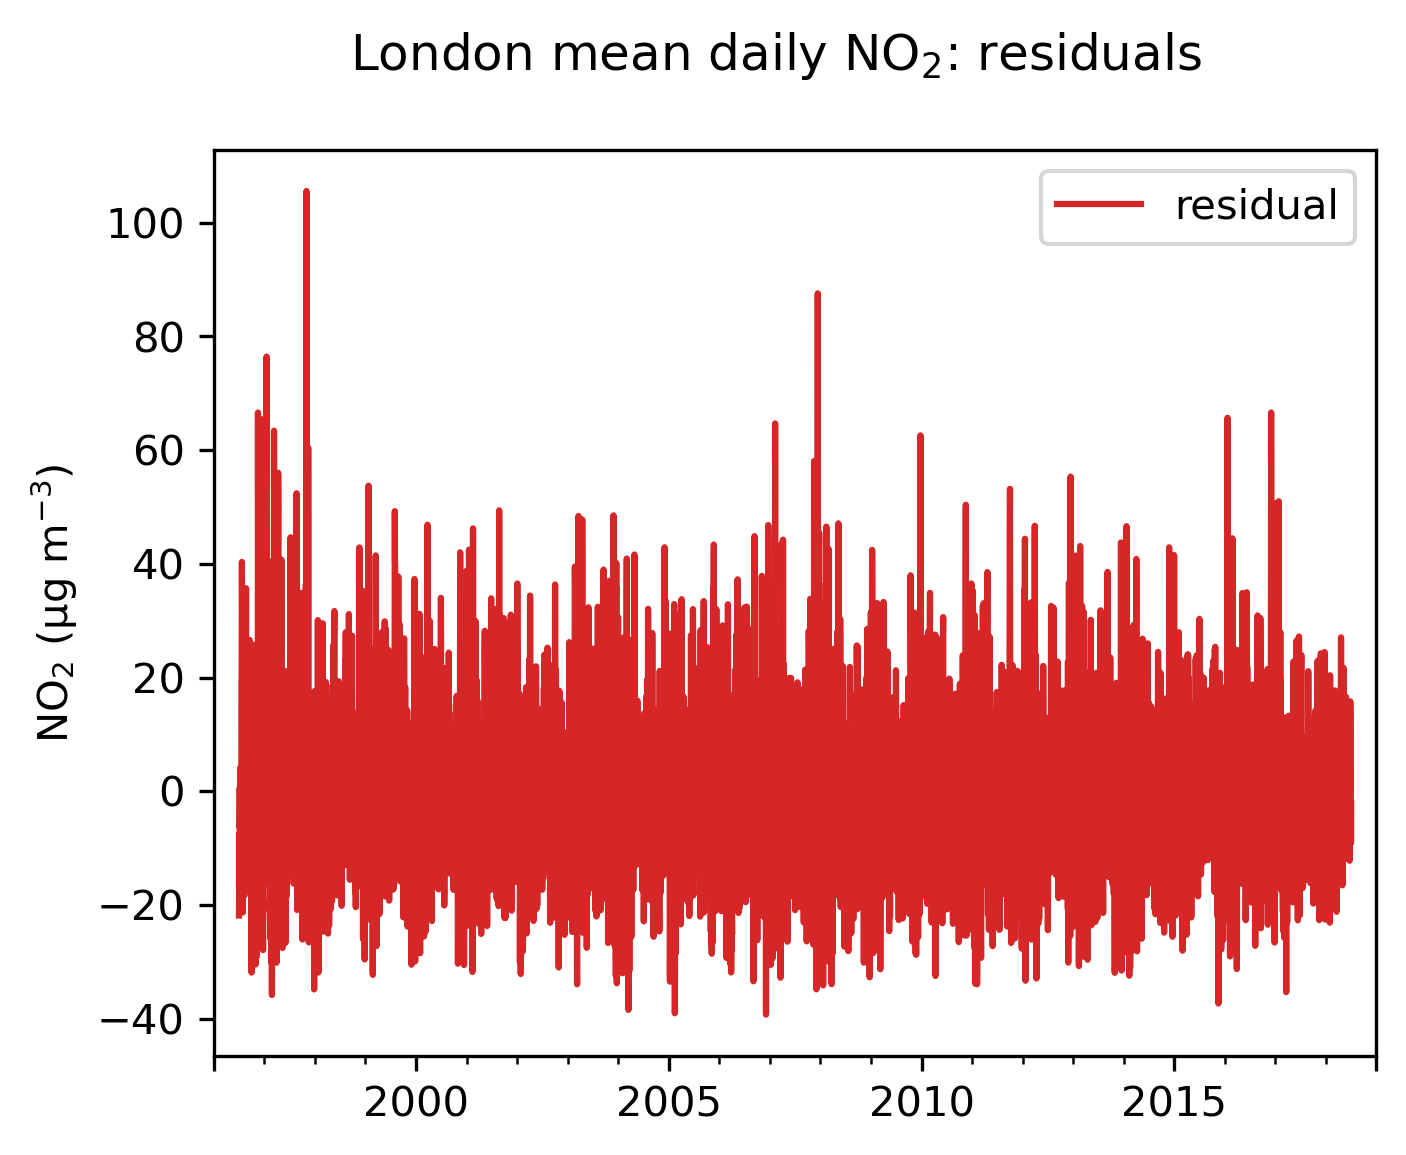

In [31]:
title = "London mean daily NO$_2$"
units = "NO$_2$ (µg m$^{-3}$)"

plot_seasonal_decomposition(title, units, decomp_df, 2010)

#### Temperature data

In [33]:
decomp = tsa.seasonal_decompose(daily_df.dropna()["temperature"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_dict["temperature"] = decomp_df

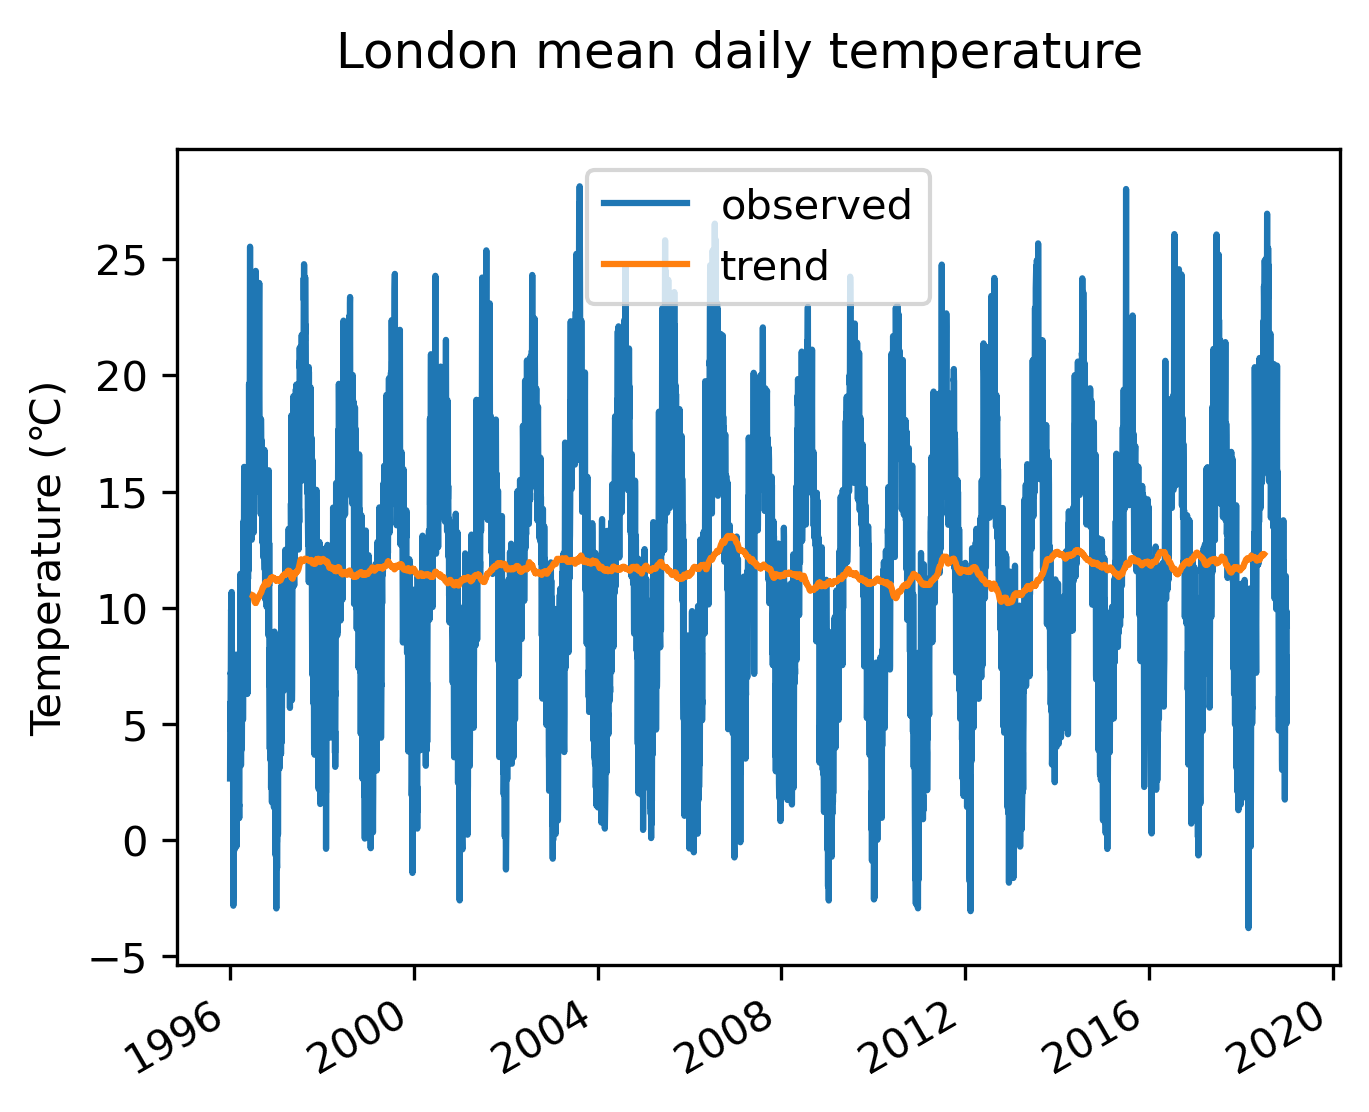

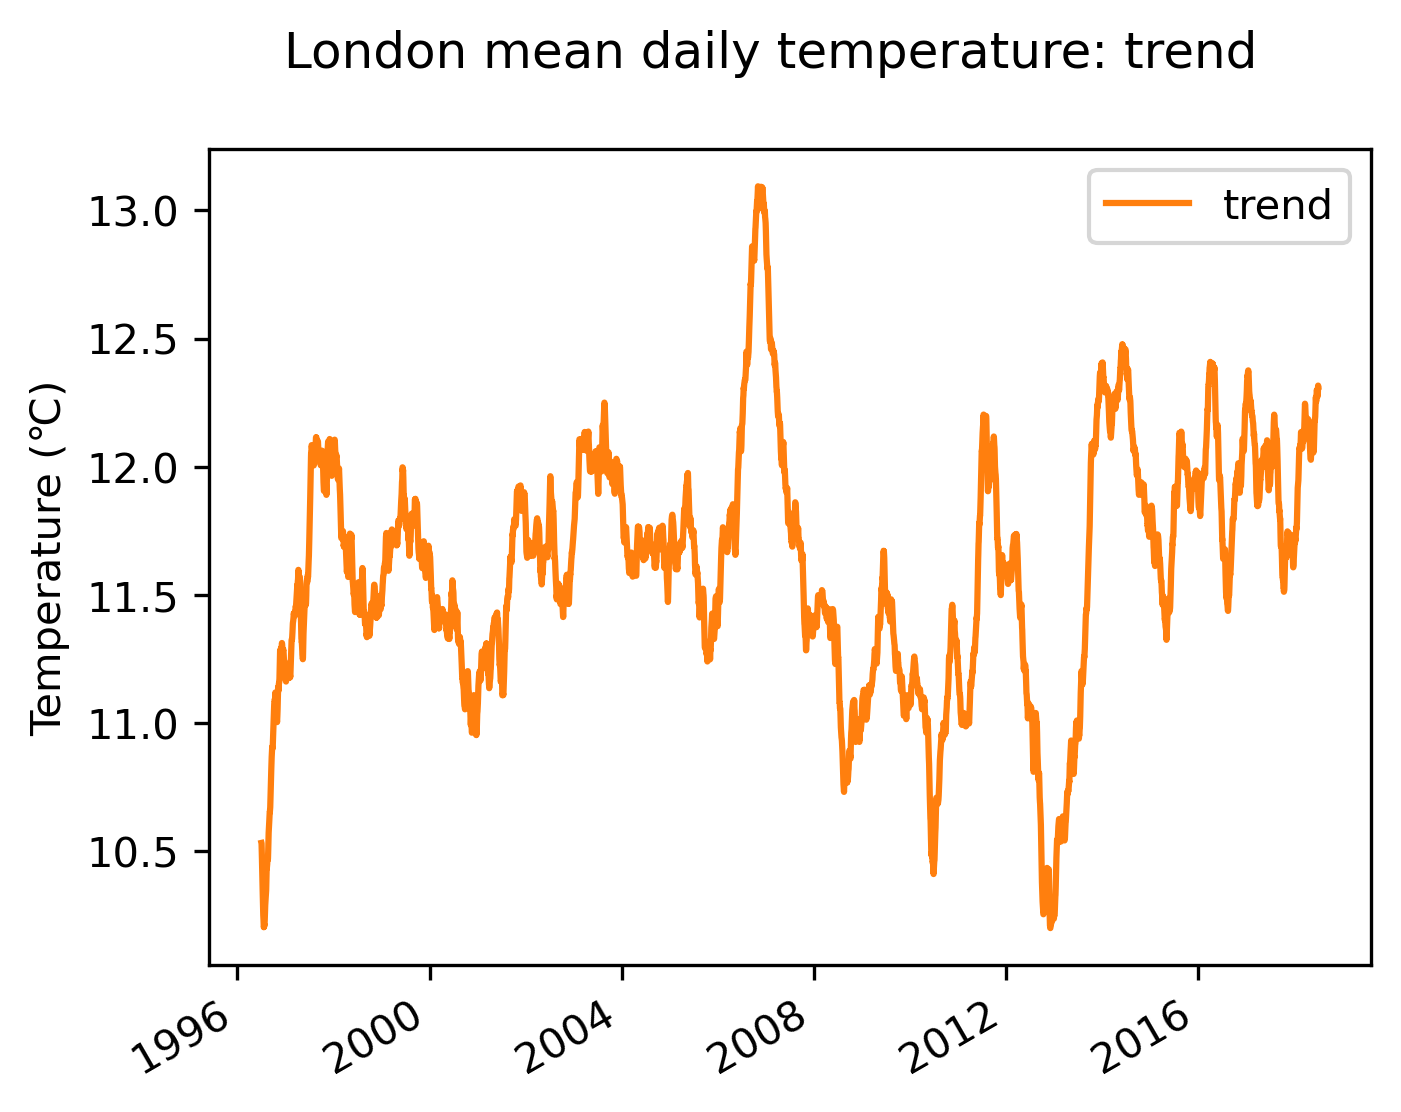

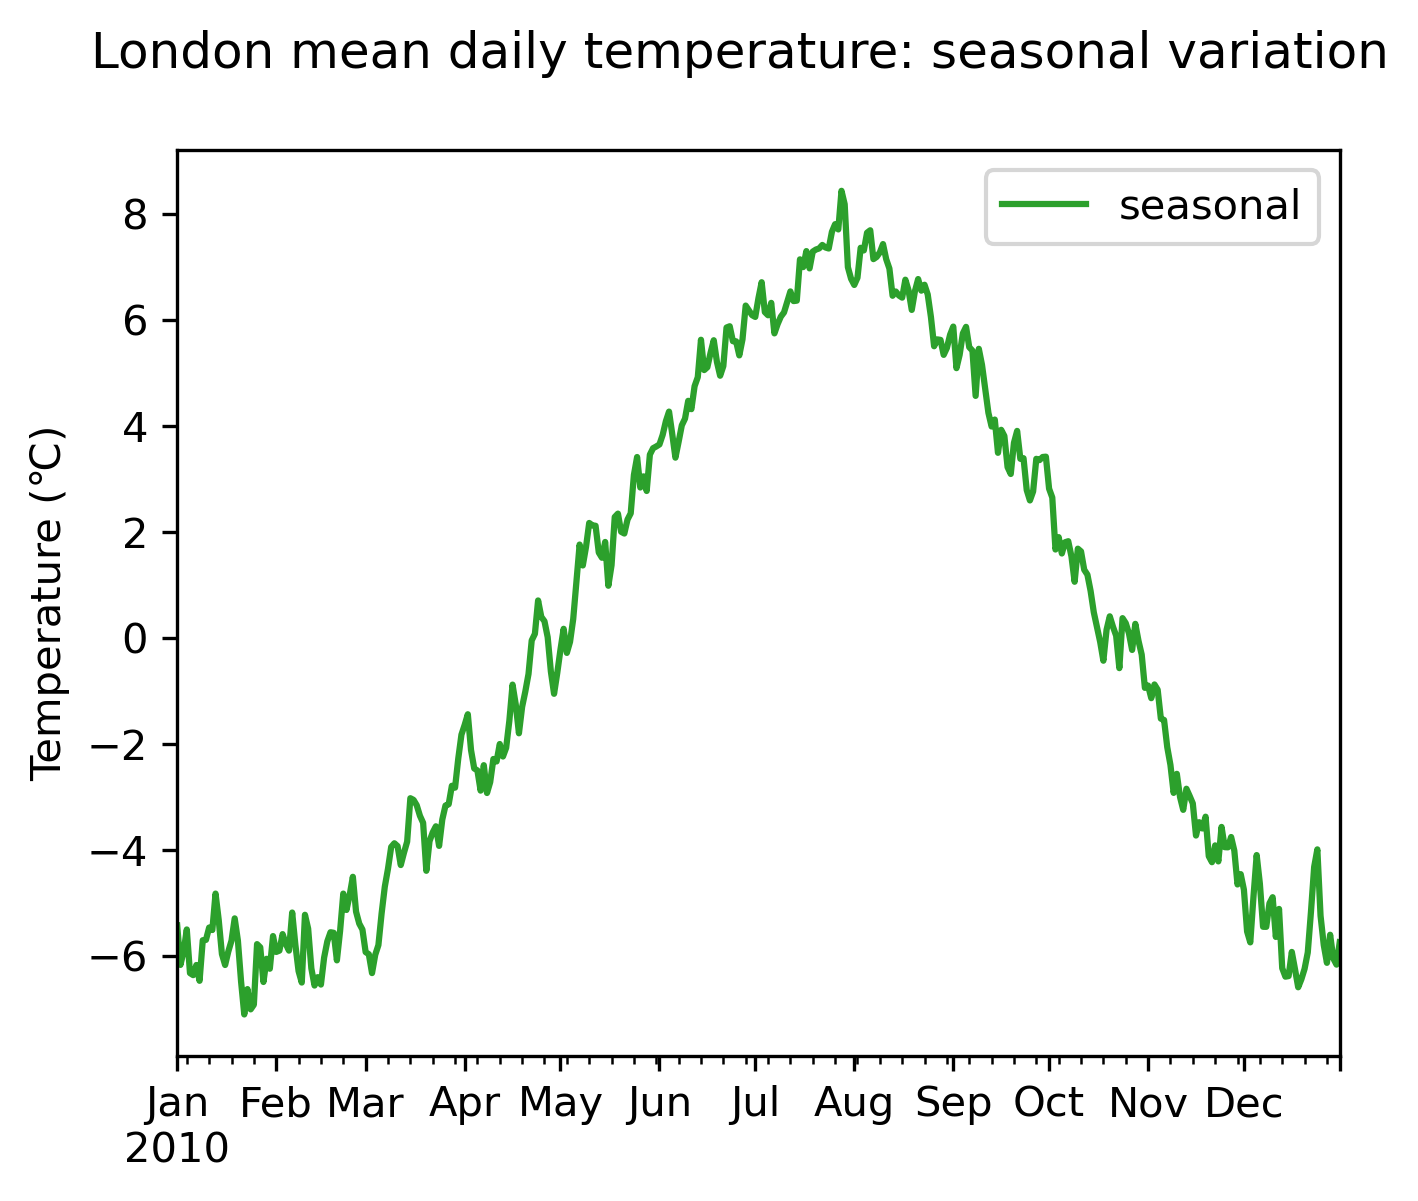

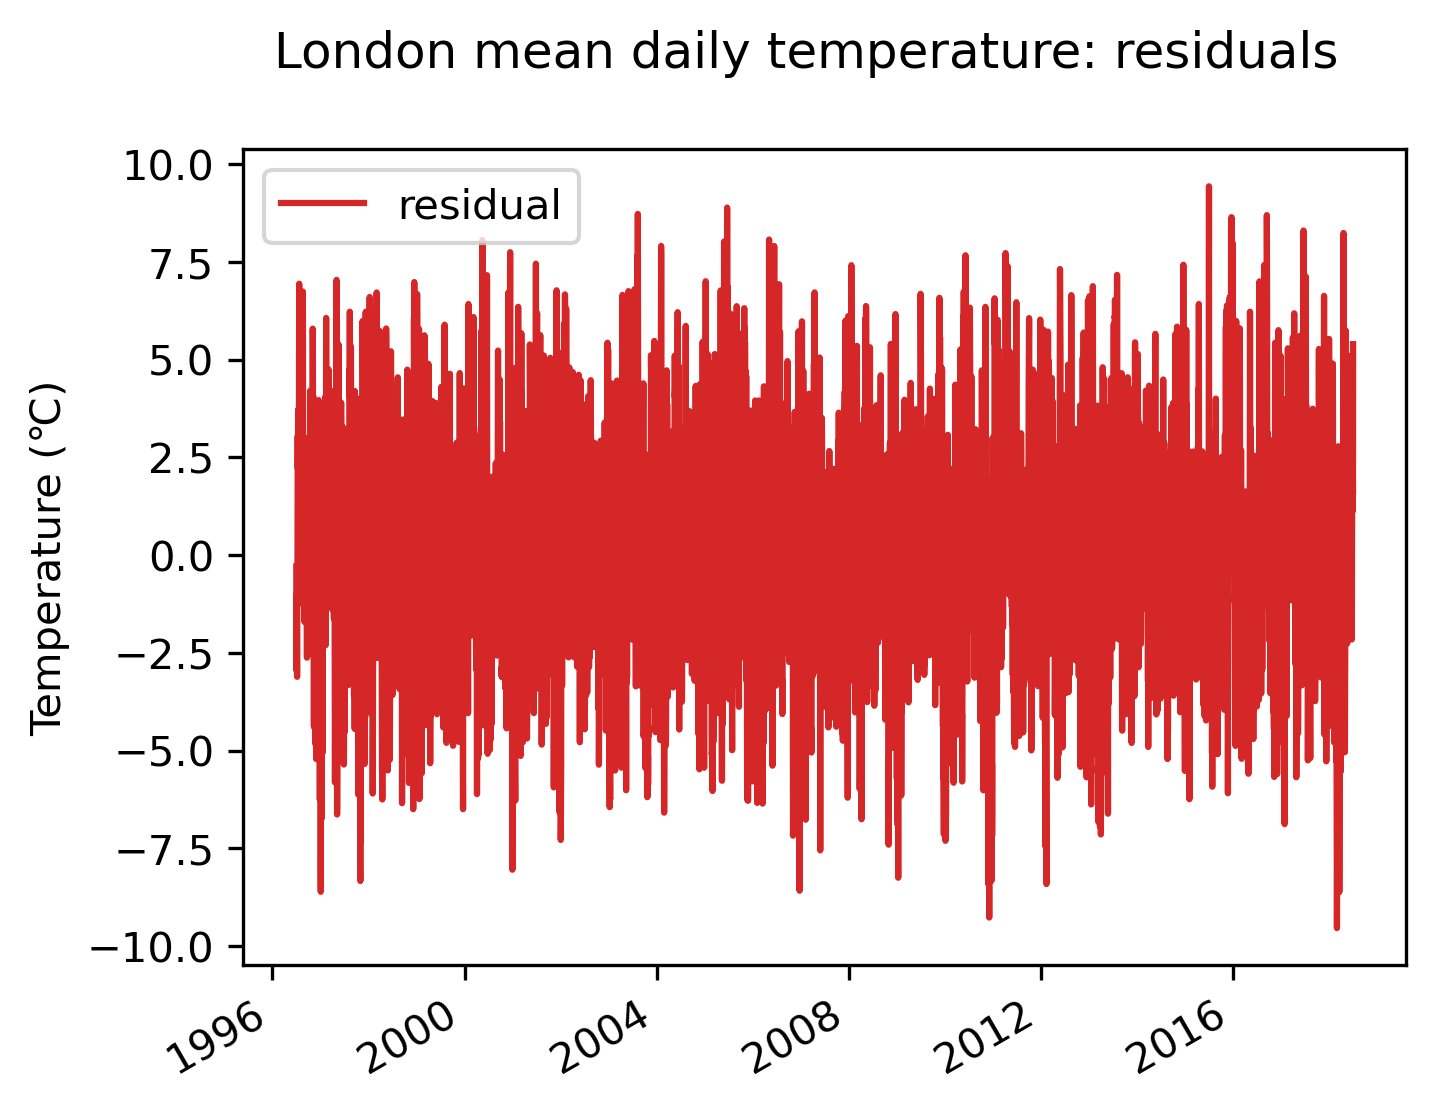

In [34]:
title = "London mean daily temperature"
units = "Temperature (℃)"

plot_seasonal_decomposition(title, units, decomp_df, 2010)

#### Disposable income trend vs mortality plots

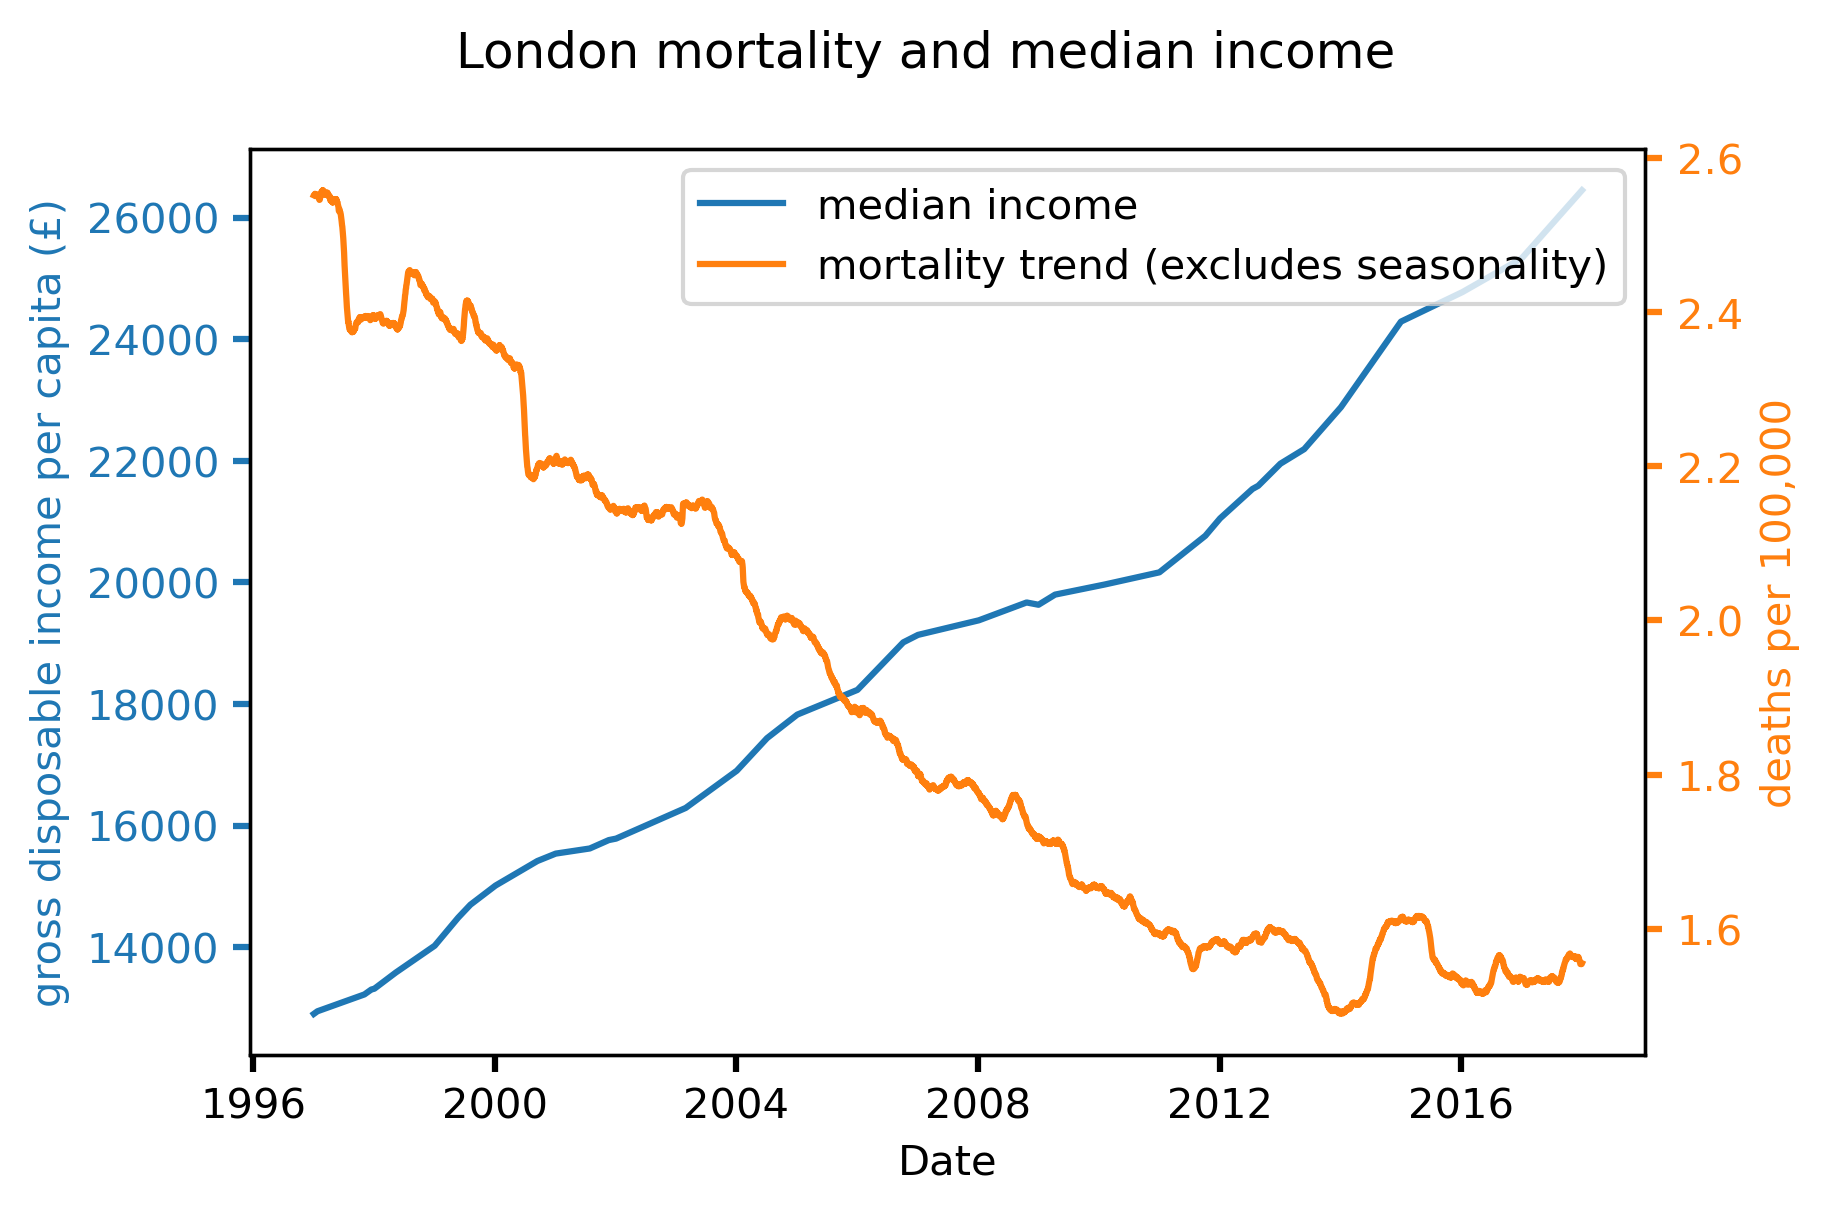

In [40]:
decomp_df = pd.DataFrame(income_df["income"]).join(pd.DataFrame({"mortality_trend":decomp_dict["mortality"].trend}))

# decomp_df["income"].plot(label="income").set_ylabel("mean daily disposable income (£)")
# decomp_df["mortality_trend"].plot(label="mortality").set_ylabel("mortality trend")
# plt.twinx()
# plt.legend()
# plt.ylabel("mean daily disposable income (£)")
# plt.suptitle("London disposable income")
# plt.show()

fig, ax = plt.subplots(figsize=(6,4), dpi=300)
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1, = ax.plot(decomp_df.index, decomp_df["income"],"tab:blue", label="median income")
p2, = twin1.plot(decomp_df.index, decomp_df["mortality_trend"], "tab:orange", label="mortality trend (excludes seasonality)")

ax.set_xlabel("Date")
ax.set_ylabel("gross disposable income per capita (£)")
twin1.set_ylabel("deaths per 100,000")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

plt.legend(handles=[p1, p2])
plt.suptitle("London mortality and median income")

plt.show()

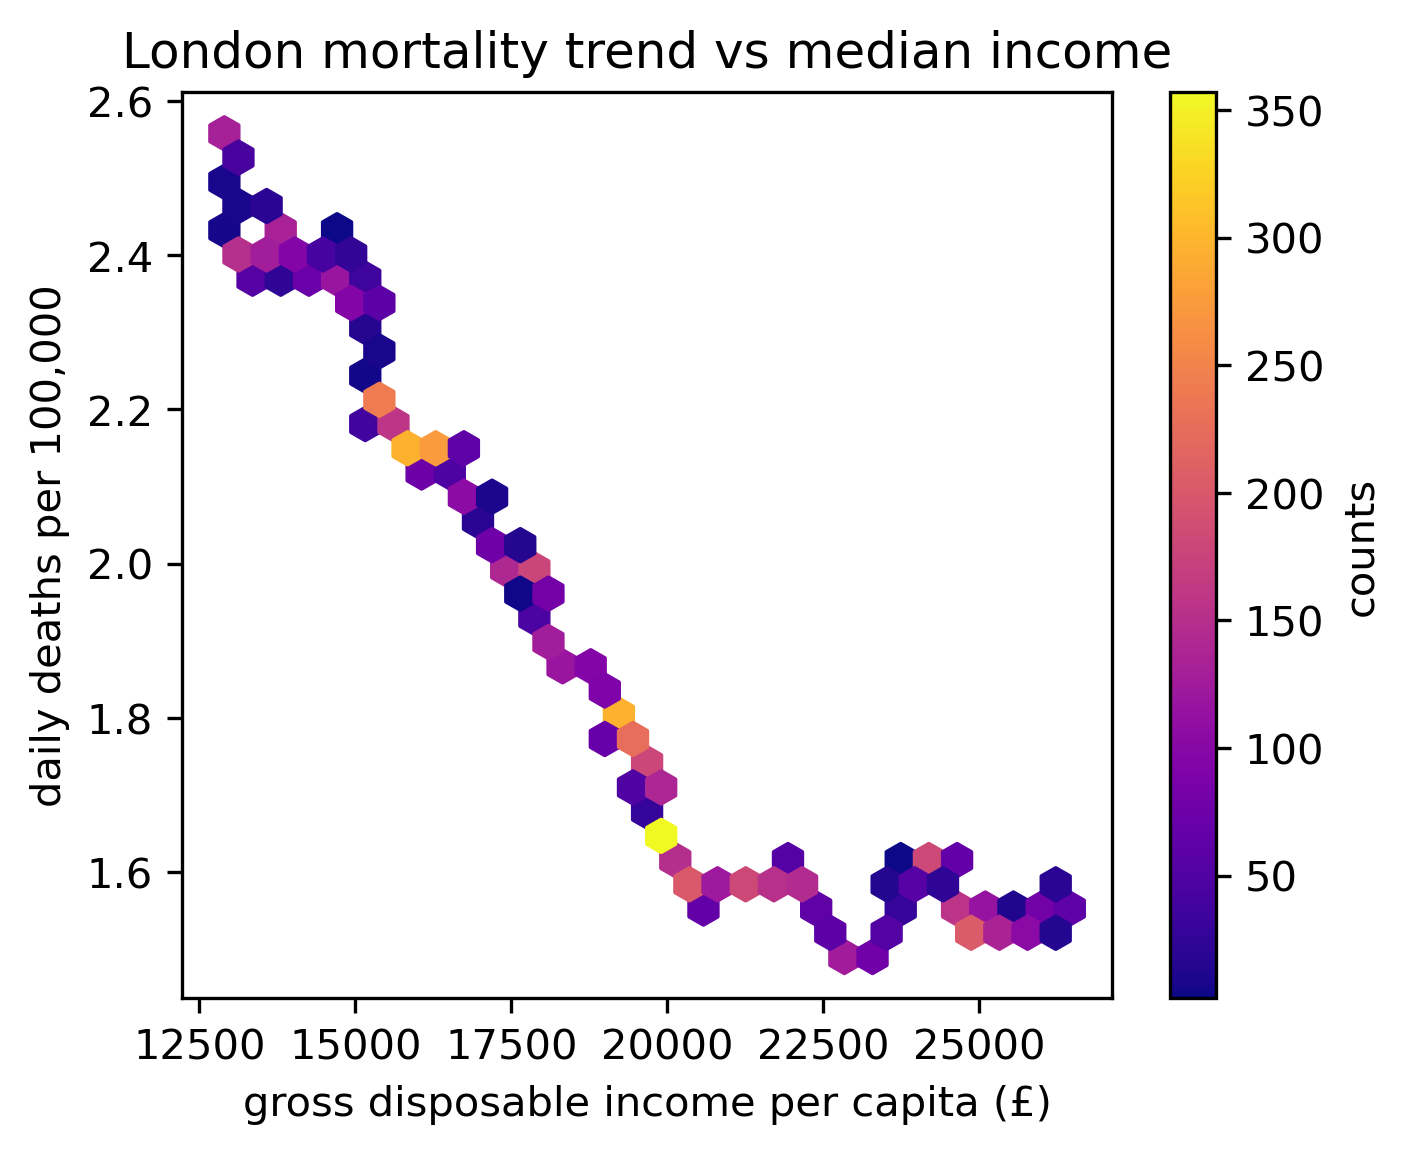

In [54]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(decomp_df.income, decomp_df.mortality_trend, cmap=cm.plasma, gridsize=30, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("gross disposable income per capita (£)")
plt.title("London mortality trend vs median income")
plt.colorbar().set_label("counts")
plt.show()

## Mortality de-trended vs temperature

Are the mortality vs temperature correlation clusters due to the mortality trend through time?
- Plot mortality seasonal+residual against temperature.

In [59]:
data_df = pd.DataFrame(decomp_dict["mortality"].seasonal + decomp_dict["mortality"].residual).join(pd.DataFrame(decomp_dict["temperature"].observed)).dropna()
data_df.columns = ["mortality_detrended","temperature_observed"]

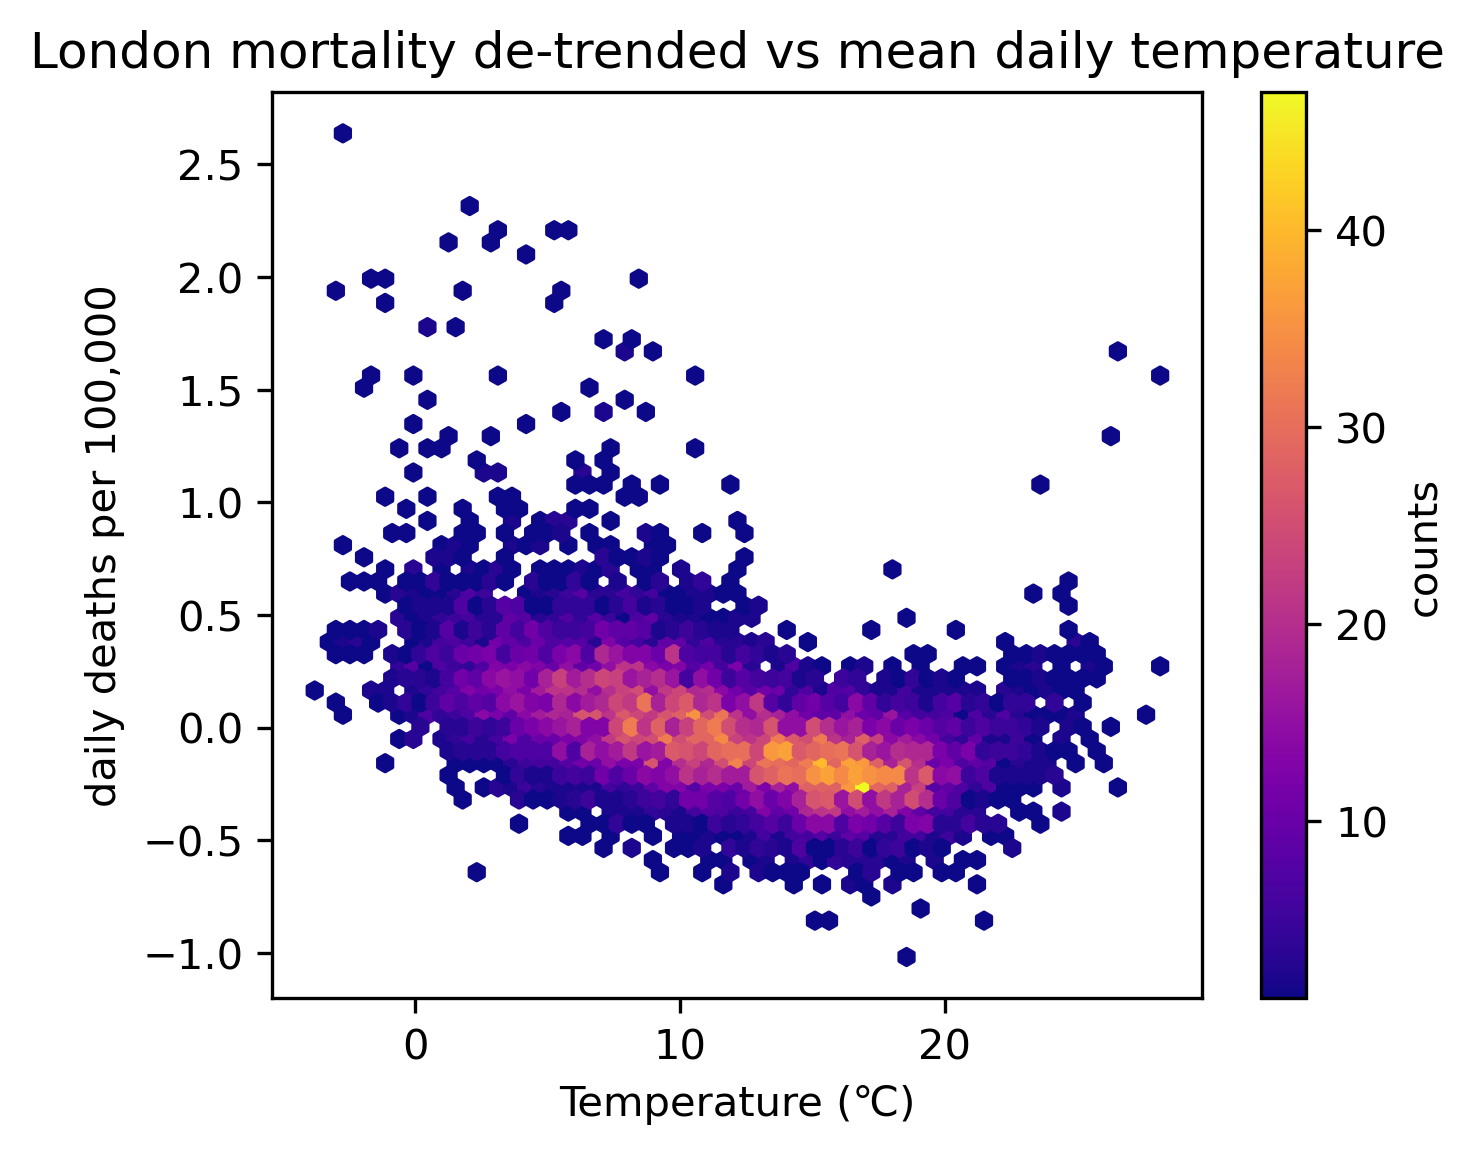

In [65]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(data_df.temperature_observed, data_df.mortality_detrended, cmap=cm.plasma, gridsize=60, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("Temperature (℃)")
plt.title("London mortality de-trended vs mean daily temperature")
plt.colorbar().set_label("counts")
plt.show()

### Mortality de-seasonalised vs GDHI
Mortality trend+residuals against GDHI

In [83]:
data_df = pd.DataFrame(decomp_dict["mortality"].trend + decomp_dict["mortality"].residual).join(income_df["income"]).dropna()
data_df.columns = ["mortality_deseasonalised","GDHI_observed"]

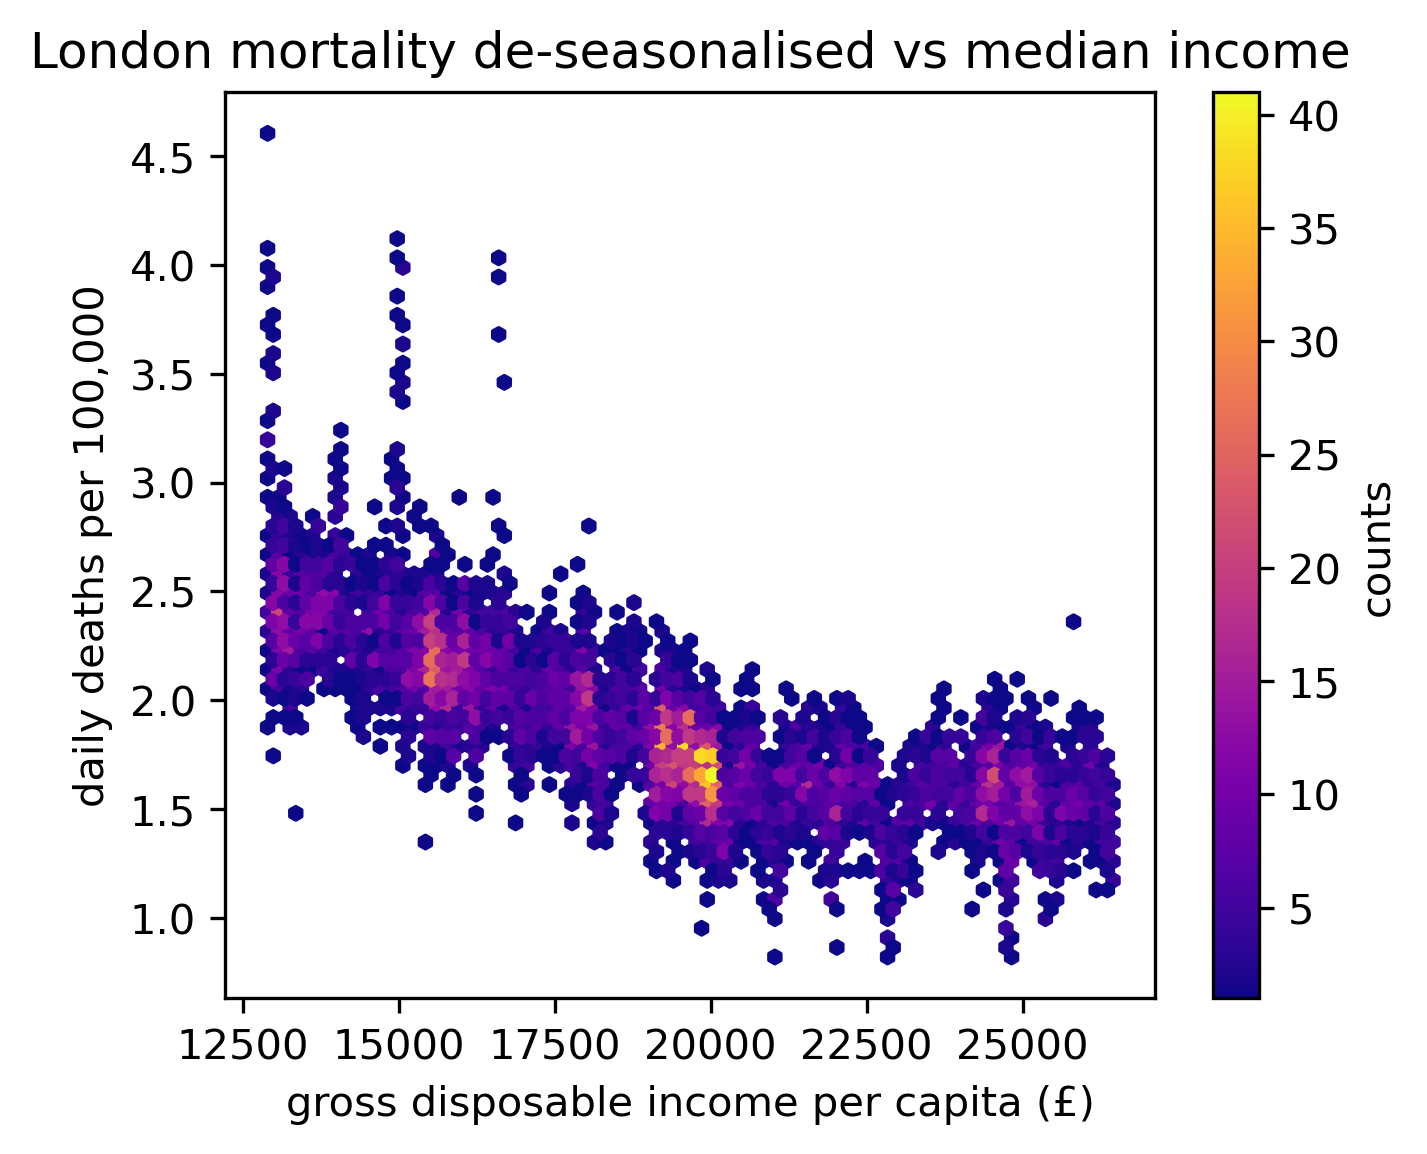

In [77]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(data_df.GDHI_observed, data_df.mortality_deseasonalised, cmap=cm.plasma, gridsize=75, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("gross disposable income per capita (£)")
plt.title("London mortality de-seasonalised vs median income")
plt.colorbar().set_label("counts")
plt.show()

In [84]:
data_df = pd.DataFrame(decomp_dict["mortality"].trend + decomp_dict["mortality"].residual, columns=["mortality_deseasonalised"]).join(pd.DataFrame(decomp_dict["NO2"].trend + decomp_dict["NO2"].residual, columns=["NO2_deseasonalised"])).dropna()

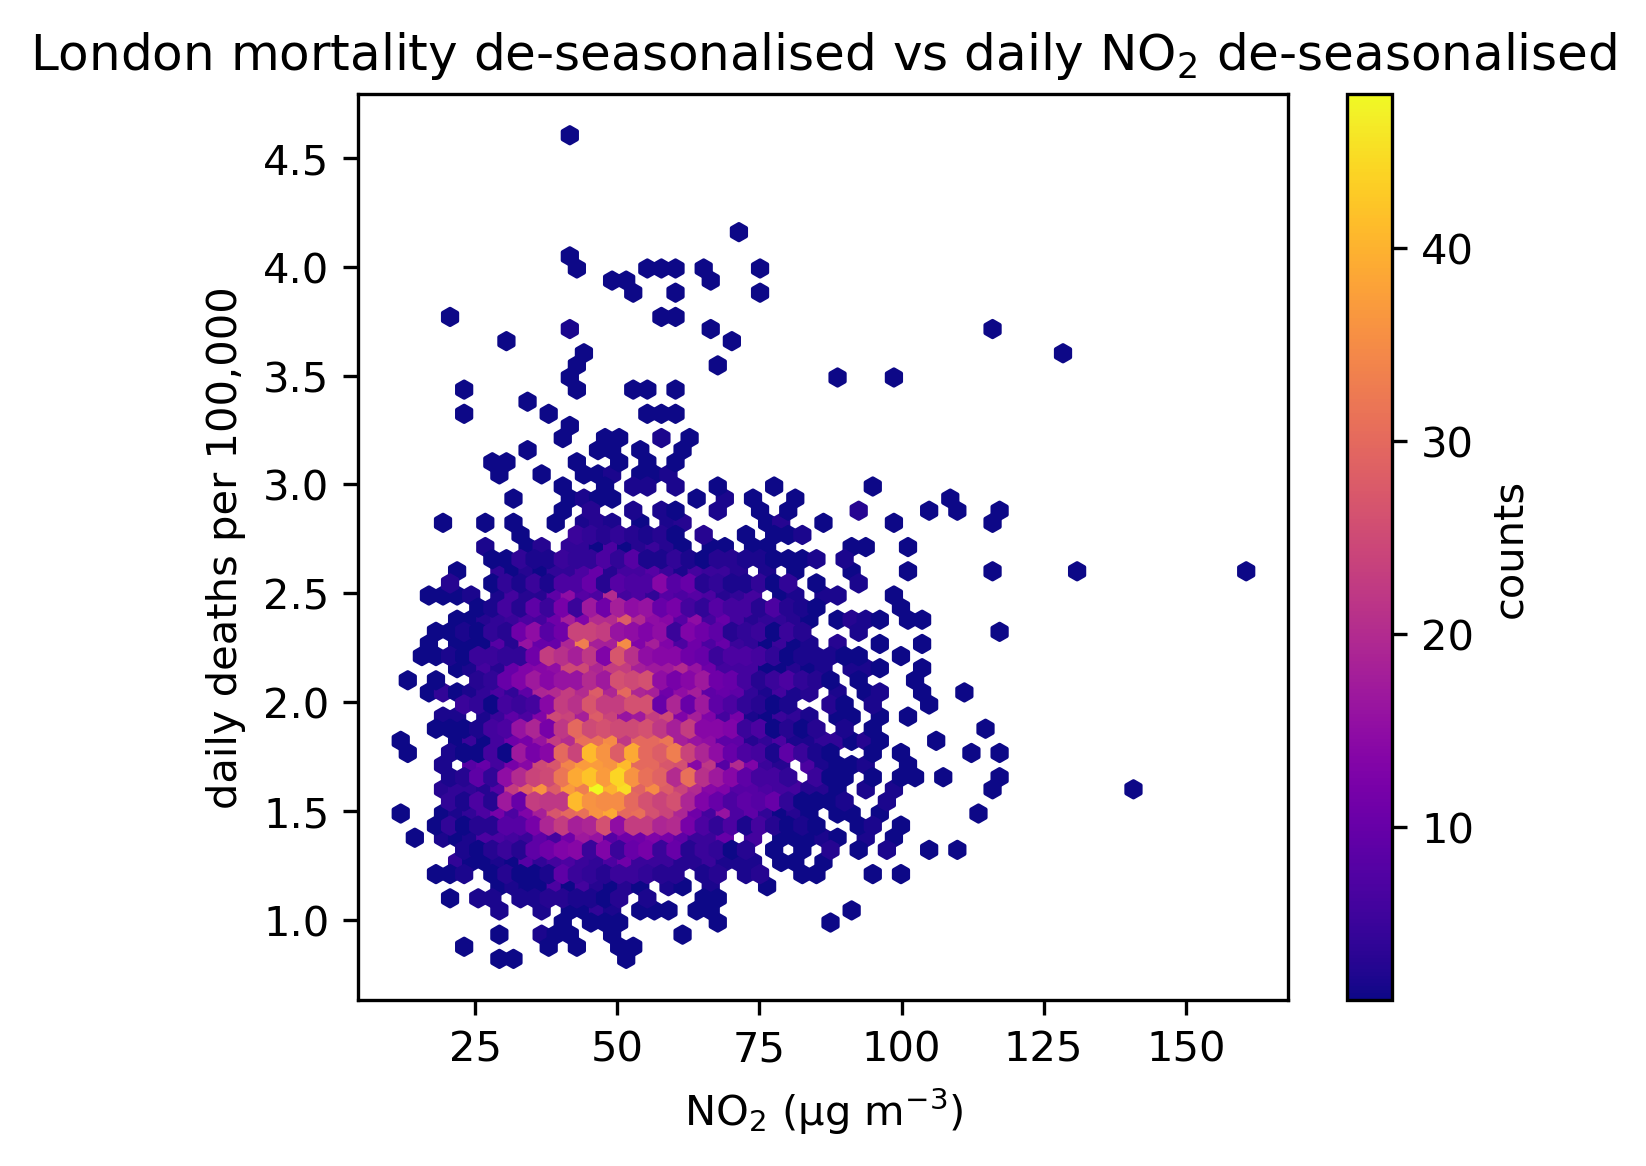

In [88]:
plt.figure(figsize=(5,4), dpi=300)
plt.hexbin(data_df.NO2_deseasonalised, data_df.mortality_deseasonalised, cmap=cm.plasma, gridsize=60, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("NO$_2$ (µg m$^{-3}$)")
plt.title("London mortality de-seasonalised vs daily NO$_2$ de-seasonalised")
plt.colorbar().set_label("counts")
plt.show()